With this notebook you can reproduce the results from the paper <br> **X-ray irradiation and evaporation of the four young planets around V1298 Tau - Poppenhaeger, Ketzer, Mallonn (2020)**
.

# Import

In [1]:
import sys
import os

# Planet Classes
sys.path.append('../platypos_package/')
from Planet_class_LoFo14_PAPER import planet_LoFo14_PAPER # this is the code with fixed step size
from Planet_class_LoFo14 import planet_LoFo14 # this is the code with variable step size
from Planet_class_Ot20_PAPER import planet_Ot20_PAPER # this is the code with fixed step size
from Planet_class_Ot20 import planet_Ot20  # this is the code with variable step size
import Planet_models_LoFo14 as plmo14
import Planet_model_Ot20 as plmoOt20
from Lx_evo_and_flux import  Lx_evo, flux_at_planet_earth

# functions for evolving more than one planet at once
sys.path.append('../population_evolution/')
from evolve_planet import evolve_one_planet, evolve_ensamble
from create_planet_chunks import create_planet_chunks
from create_summary_files import create_summary_files_with_final_planet_parameters
from read_in_PLATYPOS_population_results import read_results_file, read_in_PLATYPOS_results, read_in_PLATYPOS_results_dataframe

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 18, 'legend.fontsize': 14, 'axes.linewidth':1.1}) #set values globally
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import matplotlib.ticker as ticker
from astropy import constants as const
from PyAstronomy import pyasl # to fetch Exoplanet.eu cataloge
from sklearn.neighbors import KernelDensity

p = "../supplementary_files/"
# Tu et al. (2015) - model tracks
blueTu15 = pd.read_csv(p+'Lx_blue_track.csv')
redTu15 = pd.read_csv(p+'Lx_red_track.csv')
greenTu15 = pd.read_csv(p+'Lx_green_track.csv')
                    
# Jackson et al. (2012) - Lx sample
jack12 = pd.read_csv(p+"Jackson2012_Lx_clean.csv")

# Present V1298 Tau parameters, $L_x$ evolutionary tracks, and planet models
First we need to define all the necessary system parameters. <br>
This includes the host star parameters, parameters to set the shape of the assumed future $L_x$ evolutionary tracks, and the planets themselves. <br>
To model the radius evolution of the planets we use the results from *Lopez & Fortney (2014)* and *Otegi et al. (2020)*.

In [2]:
# Stellar Parameters:
# -------------------
# (David et al. 2019, Chandra observation)
L_bol, mass_star, radius_star = 0.934, 1.101, 1.345 # solar units
age_star = 23. # Myr
Lx_age = Lx_chandra = 1.3e30  # erg/s in energy band: (0.1-2.4 keV)
Lx_age_error = 1.4e29
# use dictionary to store star-parameters
star_V1298Tau = {'star_id': 'V1298Tau', 'mass': mass_star, 'radius': radius_star, 'age': age_star, 'L_bol': L_bol, 'Lx_age': Lx_age}


# Lx evolutionary tracks:
# -----------------------
# create dictionaries with all the values necessary to define the evolutionary paths (this is done by the function Lx_evo)
# this includes: starting age, age until Lx is saturated, two fixed ages at 1 & 5 Gyr which are set by the Tu et al. (2015) model tracks, 
# and (if wanted) a time interval in which and factor by which Lx drops (if you want a to mimic a track which drops fast early and then levels out).
Lx_1Gyr, Lx_5Gyr = 2.10*10**28, 1.65*10**27  # Lx value at 1 and 5 Gyr from Tu et al. (2015) model tracks

# use dictionaries to store track-parameters
track1 = {"t_start": star_V1298Tau["age"], "t_sat": 240., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}
track2 = {"t_start": star_V1298Tau["age"], "t_sat": star_V1298Tau["age"], "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}
track3 = {"t_start": star_V1298Tau["age"], "t_sat": star_V1298Tau["age"], "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 20., "Lx_drop_factor": 16.}
list_tracks = [track1, track2, track3]

# these are the tracks which use the upper and lower value of the current Lx
track1_lower = track1.copy()
track1_lower["Lx_max"] = Lx_age-Lx_age_error
track2_lower = track2.copy()
track2_lower["Lx_max"] = Lx_age-Lx_age_error
track3_lower = track3.copy()
track3_lower["Lx_max"] = Lx_age-Lx_age_error
list_tracks_lower = [track1_lower, track2_lower, track3_lower]

track1_upper = track1.copy()
track1_upper["Lx_max"] = Lx_age+Lx_age_error
track2_upper = track2.copy()
track2_upper["Lx_max"] = Lx_age+Lx_age_error
track3_upper = track3.copy()
track3_upper["Lx_max"] = Lx_age+Lx_age_error
list_tracks_upper = [track1_upper, track2_upper, track3_upper]

# additional tracks could look like this (different t_sat)
#track2_2 = {"t_start": star_V1298Tau["age"], "t_sat": 70., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 20., "Lx_drop_factor": 5.}
#track2_3 = {"t_start": star_V1298Tau["age"], "t_sat": 100., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}


# Observed planet parameters 
# --------------------------
# radius R, semi-major axis a and period P from David et al. (2019)
pl_params = pd.read_csv("../supplementary_files/V1298Tau_planet_parameters.csv", index_col=0)

R_c, R_d, R_b, R_e = pl_params.loc["planet_c"].radius, pl_params.loc["planet_d"].radius, pl_params.loc["planet_b"].radius, pl_params.loc["planet_e"].radius
a_c, a_d, a_b, a_e = pl_params.loc["planet_c"].a, pl_params.loc["planet_d"].a, pl_params.loc["planet_b"].a, pl_params.loc["planet_e"].a
P_c, P_d, P_b, P_e = pl_params.loc["planet_c"].period, pl_params.loc["planet_d"].period, pl_params.loc["planet_b"].period, pl_params.loc["planet_e"].period
pl_params.head()

,radius,a,period
planet_c,5.59,0.0825,8.24958
planet_d,6.41,0.1083,12.40320
planet_b,10.27,0.1688,24.13960
planet_e,8.74,0.3080,60.00000


## Plot current V1298 Tau $L_x$ & evolutionary tracks used in the paper

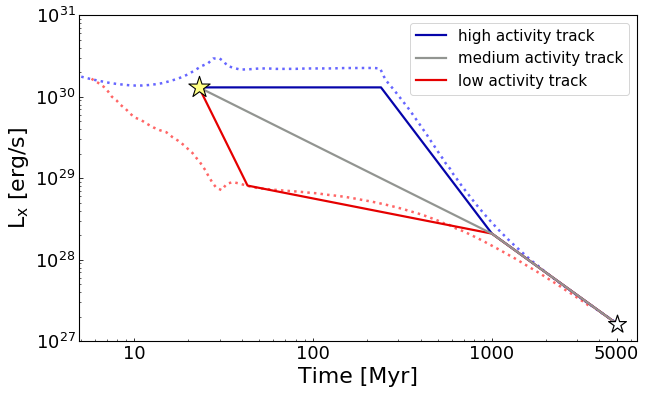

In [30]:
fig, ax = plt.subplots(figsize=(10,6))

# plot Tu15 tracks (for a Sun-like star!)
ax.plot(blueTu15["time"], blueTu15["Lx"], marker="None", linestyle=":", color="blue", linewidth=2.5, alpha=0.6, label="__nolabel__")#, label="fast rot. (solar model)")
ax.plot(redTu15["time"], redTu15["Lx"], marker="None", linestyle=":", color="red", linewidth=2.5, alpha=0.6, label="__nolabel__")#, label="slow rot. (solar model)")
#ax.plot(greenTu15["time"], greenTu15["Lx"], marker="None", linestyle=":", color="lime", linewidth=2.5, alpha=0.5, label="__nolabel__")#, label="interm. rot. (solar model)")

# plot approximated tracks
step_size, t_track_start, t_track_end = 1., star_V1298Tau["age"], 5000. # Myr
t_arr = np.arange(t_track_start, t_track_end+step_size, step_size)
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track1) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:royal blue", ls="-", zorder=2, label="high activity track", lw=2.2)
#####
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track2) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:grey", zorder=3, lw=2.2, alpha=1., label="medium activity track")
#####
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track3) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:red", zorder=2, label="low activity track", alpha=1, ls="-", lw=2.2)

# plot current X-ray luminosity of V1298 Tau as measured with Chandra & the assumed X-ray luminosity at 5 Gyr
ax.scatter(star_V1298Tau["age"], Lx_chandra, marker='*', c='xkcd:pale yellow', edgecolors='black', linewidths=1.1, s=500, alpha=1, zorder=4, label="__nolabel__")#, label="today"
ax.scatter(5000., Lx_5Gyr, marker='*', c='white', edgecolors='black', linewidths=1.2, s=350, zorder=4, label="__nolabel__")#,  label="at 5 Gyr"

ax.loglog()
ax.set_xlabel("Time [Myr]", fontsize=22)
ax.set_ylabel("L$_\mathrm{x}$ [erg/s]", fontsize=22)
ax.set_xticks([10, 100, 1000, 5000])
ax.set_yticks([10**27., 10**28., 10**29., 10**30., 10**31.])
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
ax.set_xlim(left=4.9, right=6500)
ylim = ax.get_ylim()
ax.set_ylim(abs(ylim[0]), ylim[1])
ax.set_ylim(10.**27, ylim[1])
ax.tick_params(direction="in", which="both", labelsize=18)
ax.legend(loc="best", fontsize=15)
#plt.savefig("./Plots_PAPER/Activity_tracks_v1298Tau_largelabels.jpg", dpi=300)
#plt.savefig("./Plots_PAPER/Fig8_largelabels.jpg", dpi=300)
plt.show()

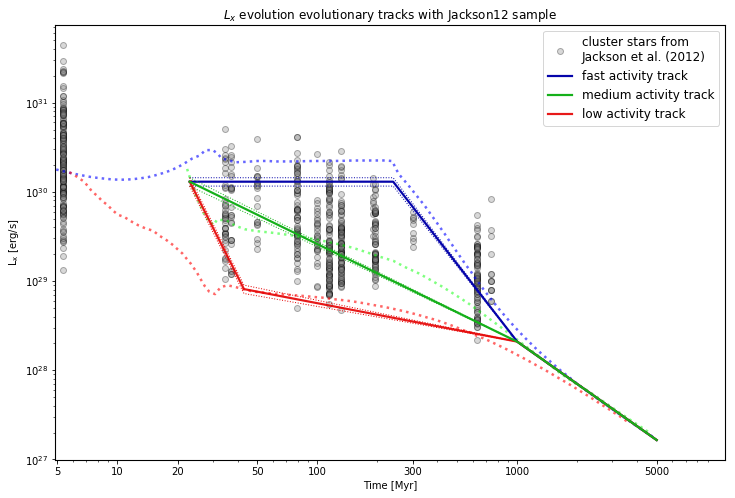

In [4]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('$L_x$ evolution evolutionary tracks with Jackson12 sample')

# plot Tu15 tracks (for a Sun-like star!)
ax.plot(blueTu15["time"], blueTu15["Lx"], marker="None", linestyle=":", color="blue", linewidth=2.5, alpha=0.6, label="__nolabel__")#, label="fast rot. (solar model)")
ax.plot(redTu15["time"], redTu15["Lx"], marker="None", linestyle=":", color="red", linewidth=2.5, alpha=0.6, label="__nolabel__")#, label="slow rot. (solar model)")
ax.plot(greenTu15["time"], greenTu15["Lx"], marker="None", linestyle=":", color="lime", linewidth=2.5, alpha=0.5, label="__nolabel__")#, label="interm. rot. (solar model)")
ax.plot(jack12["age"]/1e6, 10**jack12["logLx_cgs"], ls="None", marker="o", color="grey", mec="k", alpha=0.3, zorder=1, label="cluster stars from \nJackson et al. (2012)")

# plot approximated tracks
step_size, t_track_start, t_track_end = 1., star_V1298Tau["age"], 5000. # Myr
t_arr = np.arange(t_track_start, t_track_end+step_size, step_size)
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track1) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:royal blue", ls="-", zorder=2, label="fast activity track", lw=2.2)
# 1 sigma errorbars on Lx at 23 Myr
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track1_lower) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:royal blue", ls=":", zorder=2, label="__nolabel__", lw=1)
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track1_upper) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:royal blue", ls=":", zorder=2, label="__nolabel__", lw=1)
#####
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track2) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:green", zorder=3, lw=2.2, alpha=1., label="medium activity track")
# 1 sigma errorbars on Lx at 23 Myr
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track2_lower) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:green", ls=":", zorder=2, label="__nolabel__", lw=1)
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track2_upper) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:green", ls=":", zorder=2, label="__nolabel__", lw=1)
#####
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track3) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:red", zorder=2, label="low activity track", alpha=0.9, ls="-", lw=2.2)
# 1 sigma errorbars on Lx at 23 Myr
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track3_lower) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:red", ls=":", zorder=2, label="__nolabel__", lw=1)
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track3_upper) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:red", ls=":", zorder=2, label="__nolabel__", lw=1)

ax.loglog()
ax.set_xlabel("Time [Myr]")
ax.set_ylabel("L$_\mathrm{x}$ [erg/s]")
ax.set_xticks([5, 10, 20, 50, 100, 300, 1000, 5000])
ax.set_yticks([10**27., 10**28., 10**29., 10**30., 10**31.])
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
ax.set_xlim(left=4.9, right=11000)
ylim = ax.get_ylim()
ax.set_ylim(abs(ylim[0]), ylim[1])
ax.legend(loc="best", fontsize=12)
#plt.savefig("./tracks_v1298Tau.png", dpi=300)
plt.show()

# Create planets for evolution calculation

The scenarios:
* "fluffy" planets with a 5 and 10 M$_\oplus$ core, and H/He envelope to match the current observed radius
* "dense" planets which follow the empirical mass-radius relation for more mature planets

To create a planet object (either from the LoFo14 class or the Ot20 class), a dictionary with the star & planet parameters needs to be passed when initializing the class object.

*NOTE*: there are four classes: planet_LoFo14_PAPER, planet_LoFo14, planet_Ot20_PAPER, planet_Ot20 <br>
In the paper we originally used a fixed step size for the foward-integration, but later added a variable step-size option, which is much faster.
For completeness, both versions are being shown below.

In [3]:
# Create planet objects using either LoFO14 or Ot20 results:
# ----------------------------------------------------------

# for fluffy LoFo14 planet, a core mass needs to be specified, in addition to the metallicity (solar or enhanced)
# based on the specified core mass and the observed radius, one can estimate the current envelope mass fraction 
# needed to produce a planet of current size -> the envelope together with the core sets the starting mass of the planets
# for the dense Ot20 planets, the current mass is estimated based on the observed mass-radius relation in Otegi et al. (2020)

###############################################################################################
Mcore5, Mcore10, metallicity = 5., 10., "solarZ"
# 'fluffy' LoFo14 planets with 5 M_earth core
planet_c = {"core_mass": Mcore5, "radius": R_c, "distance": a_c, "metallicity": metallicity}
planet_d = {"core_mass": Mcore5, "radius": R_d, "distance": a_d, "metallicity": metallicity}
planet_b = {"core_mass": Mcore5, "radius": R_b, "distance": a_b, "metallicity": metallicity}
planet_e = {"core_mass": Mcore5, "radius": R_e, "distance": a_e, "metallicity": metallicity}

# fixed step size
pl_c_5_PAPER = planet_LoFo14_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_c)
pl_d_5_PAPER = planet_LoFo14_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_d)
pl_b_5_PAPER = planet_LoFo14_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_b)
pl_e_5_PAPER = planet_LoFo14_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_e)
planet_list_Mcore5_PAPER = [pl_c_5_PAPER, pl_d_5_PAPER, pl_b_5_PAPER, pl_e_5_PAPER]

# variable step size
pl_c_5 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_c)
pl_d_5 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_d)
pl_b_5 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_b)
pl_e_5 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_e)
planet_list_Mcore5 = [pl_c_5, pl_d_5, pl_b_5, pl_e_5]

###############################################################################################
# 'fluffy' LoFo14 planets with 10 M_earth core
planet_c = {"core_mass": Mcore10, "radius": R_c, "distance": a_c, "metallicity": metallicity}
planet_d = {"core_mass": Mcore10, "radius": R_d, "distance": a_d, "metallicity": metallicity}
planet_b = {"core_mass": Mcore10, "radius": R_b, "distance": a_b, "metallicity": metallicity}
planet_e = {"core_mass": Mcore10, "radius": R_e, "distance": a_e, "metallicity": metallicity}

# fixed step size
pl_c_10_PAPER = planet_LoFo14_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_c)
pl_d_10_PAPER = planet_LoFo14_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_d)
pl_b_10_PAPER = planet_LoFo14_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_b)
pl_e_10_PAPER = planet_LoFo14_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_e)
planet_list_Mcore10_PAPER = [pl_c_10_PAPER, pl_d_10_PAPER, pl_b_10_PAPER, pl_e_10_PAPER]

# variable step size
pl_c_10 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_c)
pl_d_10 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_d)
pl_b_10 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_b)
pl_e_10 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_e)
planet_list_Mcore10 = [pl_c_10, pl_d_10, pl_b_10, pl_e_10]

###############################################################################################
# 'high-density' Ot20 planets
planet_c = {"radius": R_c, "distance": a_c}
planet_d = {"radius": R_d, "distance": a_d}
planet_b = {"radius": R_b, "distance": a_b}
planet_e = {"radius": R_e, "distance": a_e}

# fixed step size
pl_c_Ot_PAPER = planet_Ot20_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_c)
pl_d_Ot_PAPER = planet_Ot20_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_d)
pl_b_Ot_PAPER = planet_Ot20_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_b)
pl_e_Ot_PAPER = planet_Ot20_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_e)
planet_list_Ot_PAPER = [pl_c_Ot_PAPER, pl_d_Ot_PAPER, pl_b_Ot_PAPER, pl_e_Ot_PAPER]

# variable step size
pl_c_Ot = planet_Ot20(star_dictionary=star_V1298Tau, planet_dict=planet_c)
pl_d_Ot = planet_Ot20(star_dictionary=star_V1298Tau, planet_dict=planet_d)
pl_b_Ot = planet_Ot20(star_dictionary=star_V1298Tau, planet_dict=planet_b)
pl_e_Ot = planet_Ot20(star_dictionary=star_V1298Tau, planet_dict=planet_e)
planet_list_Ot = [pl_c_Ot, pl_d_Ot, pl_b_Ot, pl_e_Ot]

# Evolve planets using a fixed step size (this was used in the paper, but is very slow!)

*****
**TO DO**: <br>
Run the cells below to start the evolution calculation (or immediately read in the results if already available).  <br>
**Some of the calculation results are already available in separate folders. If you want to redo them, delete the results-folders. Just remember that this will take some time with the fixed step-size code.** <br>
For each planet scenario ("fluffy" and "dense"), the planets are evolved along three tracks (high, medium and low activity). <br>
The output will be four arrays per track: t1_XXX, M1_XXX, R1_XXX, Lx1_XXX (time, mass, radius, Lx evolution). <br>
The high activity track is labeled in the variable name with a "1", the medium one with "2", and the low activity track with a "3".

Some info: <br>
* *create_planet_chunks* - this function creates the right directory structure for saving the results; for each planet in the list of planets which is passed into this function, a folder is created where the results are saved. The function returns the correct path for saving the results, and a a new list of planets (`list_planets` is divided into chunks to avoid problems with multiprocessing; only important if `list_planets` is very long -> can be ignored here!). <br> **NOTE**: the folders created for each planet are **numbered**! 
So if `list_planets` contains: [planet_c, planet_d, planet_b, planet_e], then the corresponding folders will be [planet_1, planet_2, planet_3, planet_4].

* Set the name of the folder for saving the results of one scenario, the evaporation efficiency ($\epsilon$), the initial step size and the end time of the simulation

* Initiate the multiprocessing & call *evolve_ensamble*, which takes care of the rest. This funtion evolves all the planets in `list_planets` (which, if long, is chunked up into smaller pieces -> `planet_chunks`) along all the evolutionary tracks provided in `evo_track_dict_list`; decide here if you want the $\beta$ and $K$ parameters to be turned on or set to 1.

* The results are read in by the function `read_in_PLATYPOS_results`, which returns three things:
    1. Dictionary with planet names as keys (so planet_1, planet_2,...) and a corresponding dataframe as value, which has the time, radius, mass and Lx evolution for each track stored (i.e. (4 * number of tracks) columns)
    1. Dataframe with all the initial planet parameters
    1. Dictionary with planet names as keys, and the parameters of the evolutionary tracks as values <br>
    track '1' = intermediate activity track ('track_23.0_23.0_5000.0_1.3e+30_0.0_0.0') <br>
    track '2' = low activity track ('track_23.0_23.0_5000.0_1.3e+30_20.0_16.0') <br>
    track '3' = high activity track ('track_23.0_240.0_5000.0_1.3e+30_0.0_0.0') <br>

In [4]:
# set the paths
path_up_to_playpos = os.getcwd().split("platypos")[0]
curr_path = path_up_to_playpos+'/platypos/example_V1298Tau/'

## LoFo14 planets with M$_{core}\,=\,5\,$M$_\oplus$

In [ ]:
%%time

folder_name = "results_LoFo14_Mcore5_PAPER/" 
# chunk_size...
path_save, planet_chunks = create_planet_chunks(curr_path, folder_name=folder_name, list_planets=planet_list_Mcore5_PAPER, chunk_size=4)
eps, init_step, t_final = 0.1, 0.1, 5000.

# this is where the mulit-processing happens
if __name__ == "__main__":
    # evolve the ensamble (multi-threading)
    evolve_ensamble(planet_chunks, t_final, initial_step_size=init_step, epsilon=eps, 
                    K_on="yes", beta_on="yes", evo_track_dict_list=list_tracks, path_save=path_save)
    
# read in the results as a dataframe
#planets_LoFo14_Mcore5_dict, planets_LoFo14_Mcore5_init_df, tracks_LoFo14_Mcore5_dict = read_in_PLATYPOS_results(path_to_results="./results_LoFo14_Mcore5_PAPER/", N_tracks=3)

## LoFo14 planets with M$_{core}\,=\,10\,$M$_\oplus$

In [ ]:
%%time
folder_name = "results_LoFo14_Mcore10_PAPER/"
path_save, planet_chunks = create_planet_chunks(curr_path, folder_name=folder_name, list_planets=planet_list_Mcore10_PAPER, chunk_size=4)
eps, init_step, t_final = 0.1, 0.1, 5000.

# this is where the mulit-processing happens
if __name__ == "__main__":
    evolve_ensamble(planet_chunks, t_final, initial_step_size=init_step, epsilon=eps, 
                    K_on="yes", beta_on="yes", evo_track_dict_list=list_tracks, path_save=path_save)
    

# read in the results as a dataframe
#planets_LoFo14_Mcore10_dict, planets_LoFo14_Mcore10_init_df, tracks_LoFo14_Mcore10_dict = read_in_PLATYPOS_results(path_to_results="./results_LoFo14_Mcore10_PAPER/", N_tracks=3)

## Ot20 planets 

In [ ]:
%%time
folder_name = "results_Ot20_PAPER/"
path_save, planet_chunks = create_planet_chunks(curr_path, folder_name=folder_name, list_planets=planet_list_Ot_PAPER, chunk_size=4)
eps, init_step, t_final = 0.1, 1., 5000.

# this is where the mulit-processing happens
if __name__ == "__main__":
    evolve_ensamble(planet_chunks, t_final, initial_step_size=init_step, epsilon=eps, 
                    K_on="yes", beta_on="yes", evo_track_dict_list=list_tracks, path_save=path_save)
    
# read in the results as a dataframe
#planets_Ot_dict, planets_Ot_init_df, tracks_Ot_dict = read_in_PLATYPOS_results(path_to_results="./results_Ot20_PAPER/", N_tracks=3)

# Evolve planets using a variable step size (faster & recommended)

## LoFo14 planets with M$_{core}\,=\,5\,$M$_\oplus$

In [6]:
%%time
folder_name = "results_LoFo14_Mcore5_varstep/"
path_save, planet_chunks = create_planet_chunks(curr_path, folder_name=folder_name, list_planets=planet_list_Mcore5, chunk_size=4)
eps, init_step, t_final = 0.1, 0.1, 5000.

# this is where the mulit-processing happens
if __name__ == "__main__":
    evolve_ensamble(planet_chunks, t_final, initial_step_size=init_step, epsilon=eps, 
                    K_on="yes", beta_on="yes", evo_track_dict_list=list_tracks, path_save=path_save)
    
# read in the results as a dataframe
pl_LoFo14_Mcore5_dict, pl_LoFo14_Mcore5_init_df, tracks_LoFo14_Mcore5_dict = read_in_PLATYPOS_results(path_to_results="./results_LoFo14_Mcore5_varstep/", N_tracks=3)

Folder -> results_LoFo14_Mcore5_varstep/ <- exists.
start
That took 0.0007120649019877116 minutes
Total # of planet folders =  4
Non-empty folders:  4

Total number of planets to analyze:  4
CPU times: user 83.5 ms, sys: 31.5 ms, total: 115 ms
Wall time: 134 ms


## LoFo14 planets with M$_{core}\,=\,10\,$M$_\oplus$

In [9]:
%%time
folder_name = "results_LoFo14_Mcore10_varstep/"
path_save, planet_chunks = create_planet_chunks(curr_path, folder_name=folder_name, list_planets=planet_list_Mcore10, chunk_size=4)
eps, init_step, t_final = 0.1, 0.1, 5000.

# this is where the mulit-processing happens
if __name__ == "__main__":
    evolve_ensamble(planet_chunks, t_final, initial_step_size=init_step, epsilon=eps, 
                    K_on="yes", beta_on="yes", evo_track_dict_list=list_tracks, path_save=path_save)

# read in the results as a dataframe
pl_LoFo14_Mcore10_dict, pl_LoFo14_Mcore10_init_df, tracks_LoFo14_Mcore10_dict = read_in_PLATYPOS_results(path_to_results="./results_LoFo14_Mcore10_varstep/", N_tracks=3)

Folder -> results_LoFo14_Mcore10_varstep/ <- exists.
start
That took 0.000697481632232666 minutes
Total # of planet folders =  4
Non-empty folders:  4

Total number of planets to analyze:  4
CPU times: user 69.4 ms, sys: 39.8 ms, total: 109 ms
Wall time: 120 ms


## Ot20 planets 

In [10]:
%%time
folder_name = "results_Ot20_varstep/"
path_save, planet_chunks = create_planet_chunks(curr_path, folder_name=folder_name, list_planets=planet_list_Ot, chunk_size=4)
eps, init_step, t_final = 0.1, 1.0, 5000.

# this is where the mulit-processing happens
if __name__ == "__main__":
    evolve_ensamble(planet_chunks, t_final, initial_step_size=init_step, epsilon=eps, 
                    K_on="yes", beta_on="yes", evo_track_dict_list=list_tracks, path_save=path_save)

# read in the results as a dataframe
pl_Ot_dict, pl_Ot_init_df, tracks_Ot_dict = read_in_PLATYPOS_results(path_to_results="./results_Ot20_varstep/", N_tracks=3)

Folder -> results_Ot20_varstep/ <- exists.
start
That took 0.000728456179300944 minutes
Total # of planet folders =  4
Non-empty folders:  4

Total number of planets to analyze:  4
CPU times: user 78 ms, sys: 23.6 ms, total: 102 ms
Wall time: 116 ms


# Plots from the Paper

In [11]:
# extract all the results and save as variables (NOTE: here I read in the results from the variable step size calculations)

# medium activity track
t1_c_Ot, M1_c_Ot, R1_c_Ot = pl_Ot_dict["planet_1"]["t1"], pl_Ot_dict["planet_1"]["M1"], pl_Ot_dict["planet_1"]["R1"]
t1_c_10, M1_c_10, R1_c_10 = pl_LoFo14_Mcore10_dict["planet_1"]["t1"], pl_LoFo14_Mcore10_dict["planet_1"]["M1"], pl_LoFo14_Mcore10_dict["planet_1"]["R1"]
t1_c_5, M1_c_5, R1_c_5 = pl_LoFo14_Mcore5_dict["planet_1"]["t1"], pl_LoFo14_Mcore5_dict["planet_1"]["M1"], pl_LoFo14_Mcore5_dict["planet_1"]["R1"]
t1_d_Ot, M1_d_Ot, R1_d_Ot = pl_Ot_dict["planet_2"]["t1"], pl_Ot_dict["planet_2"]["M1"], pl_Ot_dict["planet_2"]["R1"]
t1_d_10, M1_d_10, R1_d_10 = pl_LoFo14_Mcore10_dict["planet_2"]["t1"], pl_LoFo14_Mcore10_dict["planet_2"]["M1"], pl_LoFo14_Mcore10_dict["planet_2"]["R1"]
t1_d_5, M1_d_5, R1_d_5 = pl_LoFo14_Mcore5_dict["planet_2"]["t1"], pl_LoFo14_Mcore5_dict["planet_2"]["M1"], pl_LoFo14_Mcore5_dict["planet_2"]["R1"]
t1_b_Ot, M1_b_Ot, R1_b_Ot = pl_Ot_dict["planet_3"]["t1"], pl_Ot_dict["planet_3"]["M1"], pl_Ot_dict["planet_3"]["R1"]
t1_b_10, M1_b_10, R1_b_10 = pl_LoFo14_Mcore10_dict["planet_3"]["t1"], pl_LoFo14_Mcore10_dict["planet_3"]["M1"], pl_LoFo14_Mcore10_dict["planet_3"]["R1"]
t1_b_5, M1_b_5, R1_b_5 = pl_LoFo14_Mcore5_dict["planet_3"]["t1"], pl_LoFo14_Mcore5_dict["planet_3"]["M1"], pl_LoFo14_Mcore5_dict["planet_3"]["R1"]
t1_e_Ot, M1_e_Ot, R1_e_Ot = pl_Ot_dict["planet_4"]["t1"], pl_Ot_dict["planet_4"]["M1"], pl_Ot_dict["planet_4"]["R1"]
t1_e_10, M1_e_10, R1_e_10 = pl_LoFo14_Mcore10_dict["planet_4"]["t1"], pl_LoFo14_Mcore10_dict["planet_4"]["M1"], pl_LoFo14_Mcore10_dict["planet_4"]["R1"]
t1_e_5, M1_e_5, R1_e_5 = pl_LoFo14_Mcore5_dict["planet_4"]["t1"], pl_LoFo14_Mcore5_dict["planet_4"]["M1"], pl_LoFo14_Mcore5_dict["planet_4"]["R1"]

# low activity track
t2_c_Ot, M2_c_Ot, R2_c_Ot = pl_Ot_dict["planet_1"]["t2"], pl_Ot_dict["planet_1"]["M2"], pl_Ot_dict["planet_1"]["R2"]
t2_c_10, M2_c_10, R2_c_10 = pl_LoFo14_Mcore10_dict["planet_1"]["t2"], pl_LoFo14_Mcore10_dict["planet_1"]["M2"], pl_LoFo14_Mcore10_dict["planet_1"]["R2"]
t2_c_5, M2_c_5, R2_c_5 = pl_LoFo14_Mcore5_dict["planet_1"]["t2"], pl_LoFo14_Mcore5_dict["planet_1"]["M2"], pl_LoFo14_Mcore5_dict["planet_1"]["R2"]
t2_d_Ot, M2_d_Ot, R2_d_Ot = pl_Ot_dict["planet_2"]["t2"], pl_Ot_dict["planet_2"]["M2"], pl_Ot_dict["planet_2"]["R2"]
t2_d_10, M2_d_10, R2_d_10 = pl_LoFo14_Mcore10_dict["planet_2"]["t2"], pl_LoFo14_Mcore10_dict["planet_2"]["M2"], pl_LoFo14_Mcore10_dict["planet_2"]["R2"]
t2_d_5, M2_d_5, R2_d_5 = pl_LoFo14_Mcore5_dict["planet_2"]["t2"], pl_LoFo14_Mcore5_dict["planet_2"]["M2"], pl_LoFo14_Mcore5_dict["planet_2"]["R2"]
t2_b_Ot, M2_b_Ot, R2_b_Ot = pl_Ot_dict["planet_3"]["t2"], pl_Ot_dict["planet_3"]["M2"], pl_Ot_dict["planet_3"]["R2"]
t2_b_10, M2_b_10, R2_b_10 = pl_LoFo14_Mcore10_dict["planet_3"]["t2"], pl_LoFo14_Mcore10_dict["planet_3"]["M2"], pl_LoFo14_Mcore10_dict["planet_3"]["R2"]
t2_b_5, M2_b_5, R2_b_5 = pl_LoFo14_Mcore5_dict["planet_3"]["t2"], pl_LoFo14_Mcore5_dict["planet_3"]["M2"], pl_LoFo14_Mcore5_dict["planet_3"]["R2"]
t2_e_Ot, M2_e_Ot, R2_e_Ot = pl_Ot_dict["planet_4"]["t2"], pl_Ot_dict["planet_4"]["M2"], pl_Ot_dict["planet_4"]["R2"]
t2_e_10, M2_e_10, R2_e_10 = pl_LoFo14_Mcore10_dict["planet_4"]["t2"], pl_LoFo14_Mcore10_dict["planet_4"]["M2"], pl_LoFo14_Mcore10_dict["planet_4"]["R2"]
t2_e_5, M2_e_5, R2_e_5 = pl_LoFo14_Mcore5_dict["planet_4"]["t2"], pl_LoFo14_Mcore5_dict["planet_4"]["M2"], pl_LoFo14_Mcore5_dict["planet_4"]["R2"]

# high activity track
t3_c_Ot, M3_c_Ot, R3_c_Ot = pl_Ot_dict["planet_1"]["t3"], pl_Ot_dict["planet_1"]["M3"], pl_Ot_dict["planet_1"]["R3"]
t3_c_10, M3_c_10, R3_c_10 = pl_LoFo14_Mcore10_dict["planet_1"]["t3"], pl_LoFo14_Mcore10_dict["planet_1"]["M3"], pl_LoFo14_Mcore10_dict["planet_1"]["R3"]
t3_c_5, M3_c_5, R3_c_5 = pl_LoFo14_Mcore5_dict["planet_1"]["t3"], pl_LoFo14_Mcore5_dict["planet_1"]["M3"], pl_LoFo14_Mcore5_dict["planet_1"]["R3"]
t3_d_Ot, M3_d_Ot, R3_d_Ot = pl_Ot_dict["planet_2"]["t3"], pl_Ot_dict["planet_2"]["M3"], pl_Ot_dict["planet_2"]["R3"]
t3_d_10, M3_d_10, R3_d_10 = pl_LoFo14_Mcore10_dict["planet_2"]["t3"], pl_LoFo14_Mcore10_dict["planet_2"]["M3"], pl_LoFo14_Mcore10_dict["planet_2"]["R3"]
t3_d_5, M3_d_5, R3_d_5 = pl_LoFo14_Mcore5_dict["planet_2"]["t3"], pl_LoFo14_Mcore5_dict["planet_2"]["M3"], pl_LoFo14_Mcore5_dict["planet_2"]["R3"]
t3_b_Ot, M3_b_Ot, R3_b_Ot = pl_Ot_dict["planet_3"]["t3"], pl_Ot_dict["planet_3"]["M3"], pl_Ot_dict["planet_3"]["R3"]
t3_b_10, M3_b_10, R3_b_10 = pl_LoFo14_Mcore10_dict["planet_3"]["t3"], pl_LoFo14_Mcore10_dict["planet_3"]["M3"], pl_LoFo14_Mcore10_dict["planet_3"]["R3"]
t3_b_5, M3_b_5, R3_b_5 = pl_LoFo14_Mcore5_dict["planet_3"]["t3"], pl_LoFo14_Mcore5_dict["planet_3"]["M3"], pl_LoFo14_Mcore5_dict["planet_3"]["R3"]
t3_e_Ot, M3_e_Ot, R3_e_Ot = pl_Ot_dict["planet_4"]["t3"], pl_Ot_dict["planet_4"]["M3"], pl_Ot_dict["planet_4"]["R3"]
t3_e_10, M3_e_10, R3_e_10 = pl_LoFo14_Mcore10_dict["planet_4"]["t3"], pl_LoFo14_Mcore10_dict["planet_4"]["M3"], pl_LoFo14_Mcore10_dict["planet_4"]["R3"]
t3_e_5, M3_e_5, R3_e_5 = pl_LoFo14_Mcore5_dict["planet_4"]["t3"], pl_LoFo14_Mcore5_dict["planet_4"]["M3"], pl_LoFo14_Mcore5_dict["planet_4"]["R3"]

## Plot mass & radius evolution planet c

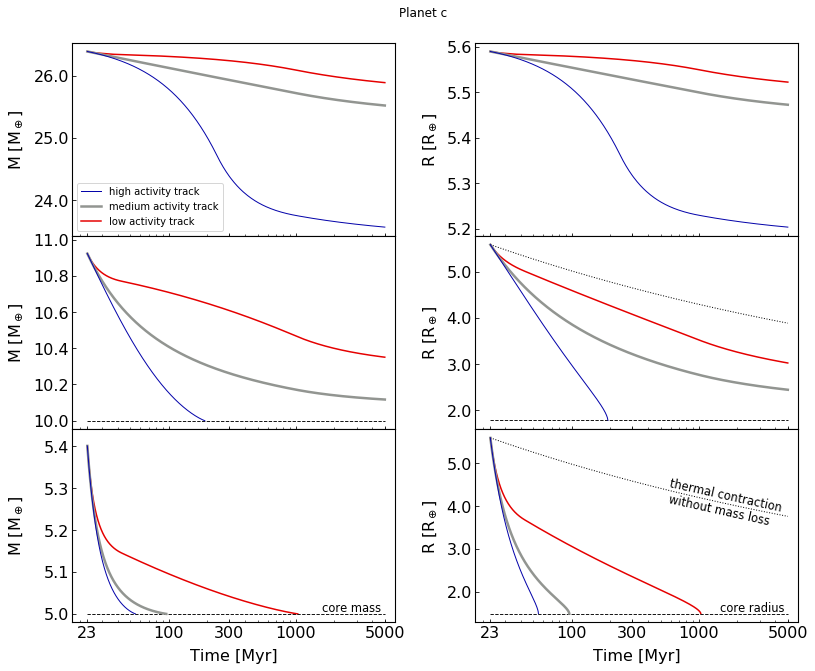

In [12]:
fig, axs = plt.subplots(3,2, figsize=(13,10), sharex=True, sharey=False)
fig.suptitle("Planet c")
fig.subplots_adjust(top=0.93)

# masses
# Otegi/heavy
axs[0, 0].plot(t3_c_Ot, M3_c_Ot, label="high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t1_c_Ot, M1_c_Ot, label="medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 0].plot(t2_c_Ot, M2_c_Ot, label="low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 0].plot(t3_c_10, M3_c_10, ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t1_c_10, M1_c_10, ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 0].plot(t2_c_10, M2_c_10, ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[1, 0].hlines(pl_c_10.core_mass, t1_c_10[0], 5000., linestyle="--", color="k", lw=0.9)

# 5Mcore
axs[2, 0].plot(t3_c_5, M3_c_5, ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t1_c_5, M1_c_5, ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 0].plot(t2_c_5, M2_c_5, ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 0].hlines(pl_c_5.core_mass, t1_c_5[0], 5000., linestyle="--", color="k", lw=0.9)
axs[2, 0].text(1600, 5.006, "core mass", fontsize=11.5)

#radii
# Otegi/heavy
axs[0, 1].plot(t3_c_Ot, R3_c_Ot, ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t1_c_Ot, R1_c_Ot, ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 1].plot(t2_c_Ot, R2_c_Ot, ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 1].plot(t3_c_10, R3_c_10, ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t1_c_10, R1_c_10, ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 1].plot(t2_c_10, R2_c_10, ls="-", color="xkcd:red", lw=1.5, zorder=1)
age_arr = np.linspace(23., 5000., 1000)
axs[1, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_c_10.core_mass, pl_c_10.fenv, age_arr, pl_c_10.flux, pl_c_10.metallicity), color="k", ls=":", lw=1)
axs[1, 1].hlines(plmo14.calculate_core_radius(pl_c_10.core_mass), pl_c_10.age, 5000., linestyle="--", color="k", lw=0.9)

dy = 1.25
axs[2, 1].text(575, 3.19+dy, "thermal contraction", fontsize=11.5, rotation=-12.5)
axs[2, 1].text(570, 2.82+dy, "without mass loss", fontsize=11.5, rotation=-12.5)

# 5 mcore
axs[2, 1].plot(t3_c_5, R3_c_5, ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t1_c_5, R1_c_5, ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 1].plot(t2_c_5, R2_c_5, ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_c_5.core_mass, pl_c_5.fenv, age_arr, pl_c_5.flux, pl_c_5.metallicity), color="k", ls=":", lw=1)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_c_5.core_mass), pl_c_5.age, 5000., linestyle="--", color="k", lw=0.9)
axs[2, 1].text(1475, 1.55, "core radius", fontsize=11.5)

axs[0, 0].legend(fontsize=10, loc=3)
for ax in [axs[0, 0], axs[1, 0], axs[2, 0]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('M [M$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

ylim = axs[2, 0].get_ylim()
axs[2, 0].set_ylim(top=ylim[1]+0.02)
ylim = axs[1, 0].get_ylim()
axs[1, 0].set_ylim(top=11.02)
    
for ax in [axs[0, 1], axs[1, 1], axs[2, 1]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('R [R$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

plt.subplots_adjust(hspace=0, wspace=0.25)
fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])
#plt.tight_layout()
#plt.savefig("./Plots_PAPER/planet_c_EVO_eps01.jpg", dpi=300)
plt.show()

### Planet c - larger labels for in-text plot

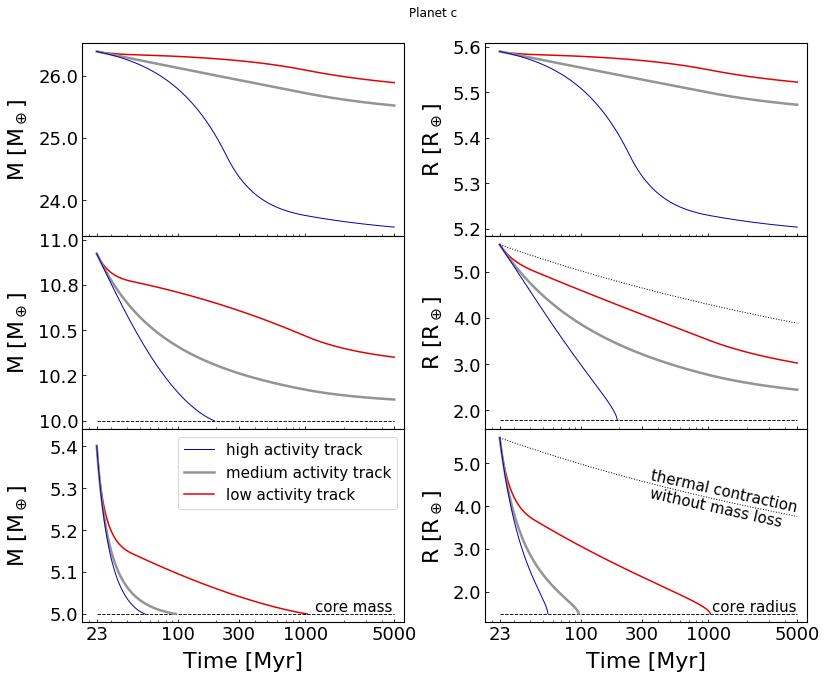

In [13]:
fig, axs = plt.subplots(3,2, figsize=(13,10), sharex=True, sharey=False)
fig.suptitle("Planet c")
fig.subplots_adjust(top=0.93)

# Otegi/heavy
axs[0, 0].plot(t3_c_Ot, (M3_c_Ot), ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t1_c_Ot, (M1_c_Ot), ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 0].plot(t2_c_Ot, (M2_c_Ot), ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 0].plot(t3_c_10, (M3_c_10), ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t1_c_10, (M1_c_10), ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 0].plot(t2_c_10, (M2_c_10), ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[1, 0].hlines(pl_c_10_PAPER.core_mass, t3_c_10[0], 5000., linestyle="--", color="k", lw=0.9)

# 5Mcore
axs[2, 0].plot(t3_c_5, (M3_c_5), label="high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t1_c_5, (M1_c_5), label="medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 0].plot(t2_c_5, (M2_c_5), label="low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 0].hlines(pl_c_5_PAPER.core_mass, t3_c_5[0], 5000., linestyle="--", color="k", lw=0.9)
axs[2, 0].text(1200, 5.006, "core mass", fontsize=15)

#radii
# Otegi/heavy
axs[0, 1].plot(t3_c_Ot, (R3_c_Ot), ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t1_c_Ot, (R1_c_Ot), ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 1].plot(t2_c_Ot, (R2_c_Ot), ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 1].plot(t3_c_10, (R3_c_10), ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t1_c_10, (R1_c_10), ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 1].plot(t2_c_10, (R2_c_10), ls="-", color="xkcd:red", lw=1.5, zorder=1)
age_arr = np.linspace(23., 5000., 1000)
axs[1, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_c_10.core_mass, pl_c_10.fenv, age_arr, pl_c_10.flux, pl_c_10.metallicity), color="k", ls=":", lw=1)
axs[1, 1].hlines(plmo14.calculate_core_radius(pl_c_10.core_mass), pl_c_10.age, 5000., linestyle="--", color="k", lw=0.9)

dy = 1.3
axs[2, 1].text(345, 3.31+dy, "thermal contraction", fontsize=15, rotation=-12.5)
axs[2, 1].text(340, 2.9+dy, "without mass loss", fontsize=15, rotation=-12.5)

# 5 mcore
axs[2, 1].plot(t3_c_5, (R3_c_5), ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t1_c_5, (R1_c_5), ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 1].plot(t2_c_5, (R2_c_5), ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_c_5.core_mass, pl_c_5.fenv, age_arr, pl_c_5.flux, pl_c_5.metallicity), color="k", ls=":", lw=1)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_c_5.core_mass), pl_c_5.age, 5000., linestyle="--", color="k", lw=0.9)
axs[2, 1].text(1075, 1.55, "core radius", fontsize=15)

axs[2, 0].legend(fontsize=15)#, loc=3)
for ax in [axs[0, 0], axs[1, 0], axs[2, 0]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.tick_params(direction="in", which="both", labelsize=18)
    ax.set_xlabel("Time [Myr]", fontsize=22, labelpad=8)
    ax.set_ylabel('M [M$_\oplus$]', fontsize=22, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

ylim = axs[2, 0].get_ylim()
axs[2, 0].set_ylim(top=ylim[1]+0.02)
ylim = axs[1, 0].get_ylim()
axs[1, 0].set_ylim(top=11.02)
    
for ax in [axs[0, 1], axs[1, 1], axs[2, 1]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.tick_params(direction="in", which="both", labelsize=18)
    ax.set_xlabel("Time [Myr]", fontsize=22, labelpad=8)
    ax.set_ylabel('R [R$_\oplus$]', fontsize=22, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

plt.subplots_adjust(hspace=0, wspace=0.25)
fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])
#plt.tight_layout()
#plt.savefig("./Plots_PAPER/planet_c_EVO_eps01_largelabels.jpg", dpi=300)
#plt.savefig("./Plots_PAPER/Fig9_largelabels.jpg", dpi=300)
plt.show()

## Plot mass & radius evolution planet d

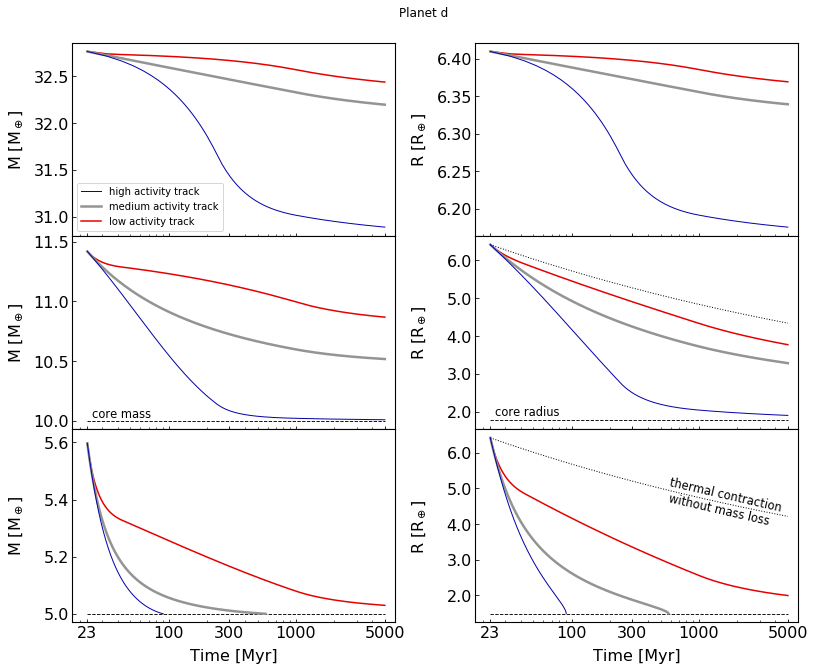

In [14]:
fig, axs = plt.subplots(3,2, figsize=(13,10), sharex=True, sharey=False)
fig.suptitle("Planet d")
fig.subplots_adjust(top=0.93)

# Otegi/heavy
axs[0, 0].plot(t3_d_Ot, (M3_d_Ot), label="high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t1_d_Ot, (M1_d_Ot), label="medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 0].plot(t2_d_Ot, (M2_d_Ot), label="low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 0].plot(t3_d_10, (M3_d_10), ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t1_d_10, (M1_d_10), ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 0].plot(t2_d_10, (M2_d_10), ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[1, 0].hlines(pl_d_10_PAPER.core_mass, t3_d_10[0], 5000., linestyle="--", color="k", lw=0.9)
axs[1, 0].text(25, 10.025, "core mass", fontsize=11.5)

# 5Mcore
axs[2, 0].plot(t3_d_5, (M3_d_5), ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t1_d_5, (M1_d_5), ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 0].plot(t2_d_5, (M2_d_5), ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 0].hlines(pl_d_5_PAPER.core_mass, t3_d_5[0], 5000., linestyle="--", color="k", lw=0.9)

#radii
# Otegi/heavy
axs[0, 1].plot(t3_d_Ot, (R3_d_Ot), ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t1_d_Ot, (R1_d_Ot), ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 1].plot(t2_d_Ot, (R2_d_Ot), ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 1].plot(t3_d_10, (R3_d_10), ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t1_d_10, (R1_d_10), ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 1].plot(t2_d_10, (R2_d_10), ls="-", color="xkcd:red", lw=1.5, zorder=1)
age_arr = np.linspace(23., 5000., 1000)
axs[1, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_d_10.core_mass, pl_d_10.fenv, age_arr, pl_d_10.flux, pl_d_10.metallicity), color="k", ls=":", lw=1)
axs[1, 1].hlines(plmo14.calculate_core_radius(pl_d_10.core_mass), pl_d_10.age, 5000., linestyle="--", color="k", lw=0.9)
axs[1, 1].text(25, 1.9, "core radius", fontsize=11.5)

# 5 mcore
axs[2, 1].plot(t3_d_5, (R3_d_5), ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t1_d_5, (R1_d_5), ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 1].plot(t2_d_5, (R2_d_5), ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_d_5.core_mass, pl_d_5.fenv, age_arr, pl_d_5.flux, pl_d_5.metallicity), color="k", ls=":", lw=1)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_d_5.core_mass), pl_d_5.age, 5000., linestyle="--", color="k", lw=0.9)
dy = 1.82
axs[2, 1].text(575, 3.25+dy, "thermal contraction", fontsize=11.5, rotation=-13)
axs[2, 1].text(570, 2.8+dy, "without mass loss", fontsize=11.5, rotation=-13)

axs[0, 0].legend(fontsize=10, loc=3)
for ax in [axs[0, 0], axs[1, 0], axs[2, 0]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('M [M$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

ylim = axs[2, 0].get_ylim()
axs[2, 0].set_ylim(top=ylim[1]+0.02)
ylim = axs[1, 0].get_ylim()
axs[1, 0].set_ylim(top=11.55)
    
for ax in [axs[0, 1], axs[1, 1], axs[2, 1]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('R [R$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

axs[0,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f')) # No decimal places
plt.subplots_adjust(hspace=0, wspace=0.25)
fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])
#plt.tight_layout()
#plt.savefig("./Plots_PAPER/planet_d_EVO_eps01.jpg", dpi=300)
plt.show()

### Planet d - larger labels for in-text plot

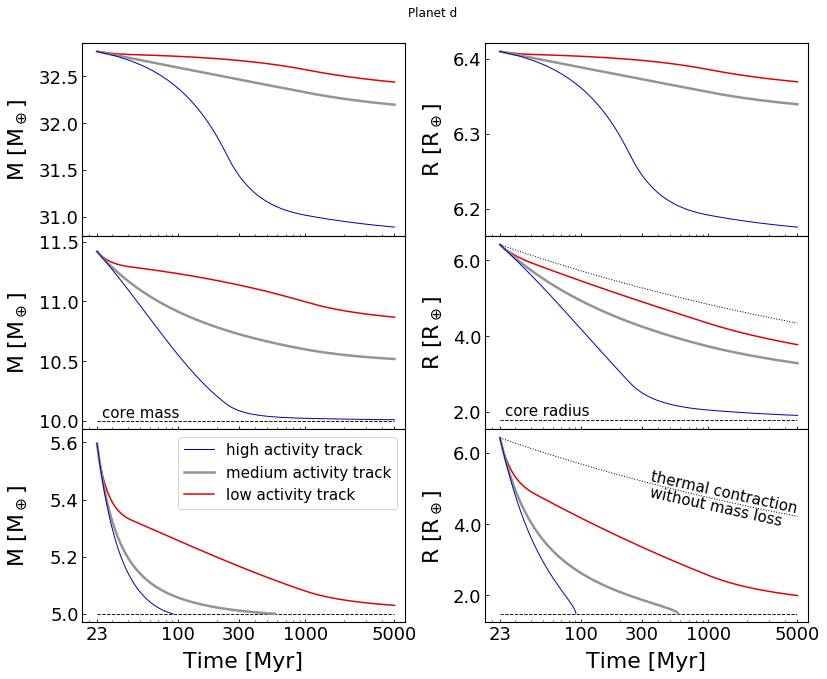

In [15]:
fig, axs = plt.subplots(3,2, figsize=(13,10), sharex=True, sharey=False)
fig.suptitle("Planet d")
fig.subplots_adjust(top=0.93)

# Otegi/heavy
axs[0, 0].plot(t3_d_Ot, (M3_d_Ot), ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t1_d_Ot, (M1_d_Ot), ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 0].plot(t2_d_Ot, (M2_d_Ot), ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 0].plot(t3_d_10, (M3_d_10), ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t1_d_10, (M1_d_10), ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 0].plot(t2_d_10, (M2_d_10), ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[1, 0].hlines(pl_d_10_PAPER.core_mass, t3_d_10[0], 5000., linestyle="--", color="k", lw=0.9)
axs[1, 0].text(25, 10.025, "core mass", fontsize=15)

# 5Mcore
axs[2, 0].plot(t3_d_5, (M3_d_5), label="high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t1_d_5, (M1_d_5), label="medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 0].plot(t2_d_5, (M2_d_5), label="low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 0].hlines(pl_d_5_PAPER.core_mass, t3_d_5[0], 5000., linestyle="--", color="k", lw=0.9)

#radii
# Otegi/heavy
axs[0, 1].plot(t3_d_Ot, (R3_d_Ot), ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t1_d_Ot, (R1_d_Ot), ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 1].plot(t2_d_Ot, (R2_d_Ot), ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 1].plot(t3_d_10, (R3_d_10), ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t1_d_10, (R1_d_10), ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 1].plot(t2_d_10, (R2_d_10), ls="-", color="xkcd:red", lw=1.5, zorder=1)
age_arr = np.linspace(23., 5000., 1000)
axs[1, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_d_10.core_mass, pl_d_10.fenv, age_arr, pl_d_10.flux, pl_d_10.metallicity), color="k", ls=":", lw=1)
axs[1, 1].hlines(plmo14.calculate_core_radius(pl_d_10.core_mass), pl_d_10.age, 5000., linestyle="--", color="k", lw=0.9)
axs[1, 1].text(25, 1.9, "core radius", fontsize=15)

# 5 mcore
axs[2, 1].plot(t3_d_5, (R3_d_5), ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t1_d_5, (R1_d_5), ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 1].plot(t2_d_5, (R2_d_5), ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_d_5.core_mass, pl_d_5.fenv, age_arr, pl_d_5.flux, pl_d_5.metallicity), color="k", ls=":", lw=1)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_d_5.core_mass), pl_d_5.age, 5000., linestyle="--", color="k", lw=0.9)
dy = 1.88
axs[2, 1].text(345, 3.33+dy, "thermal contraction", fontsize=15, rotation=-12.5)
axs[2, 1].text(340, 2.87+dy, "without mass loss", fontsize=15, rotation=-12.5)

axs[2, 0].legend(fontsize=15)
for ax in [axs[0, 0], axs[1, 0], axs[2, 0]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.tick_params(direction="in", which="both", labelsize=18)
    ax.set_xlabel("Time [Myr]", fontsize=22, labelpad=8)
    ax.set_ylabel('M [M$_\oplus$]', fontsize=22, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

ylim = axs[2, 0].get_ylim()
axs[2, 0].set_ylim(top=ylim[1]+0.02)
ylim = axs[1, 0].get_ylim()
axs[1, 0].set_ylim(top=11.55)
    
for ax in [axs[0, 1], axs[1, 1], axs[2, 1]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.tick_params(direction="in", which="both", labelsize=18)
    ax.set_xlabel("Time [Myr]", fontsize=22, labelpad=8)
    ax.set_ylabel('R [R$_\oplus$]', fontsize=22, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

axs[0,1].yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places
plt.subplots_adjust(hspace=0, wspace=0.25)
fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])
#plt.tight_layout()
#plt.savefig("./Plots_PAPER/planet_d_EVO_eps01_largelabels.jpg", dpi=300)
#plt.savefig("./Plots_PAPER/Fig10_largelabels.jpg", dpi=300)
plt.show()

## Plot mass & radius evolution planet b

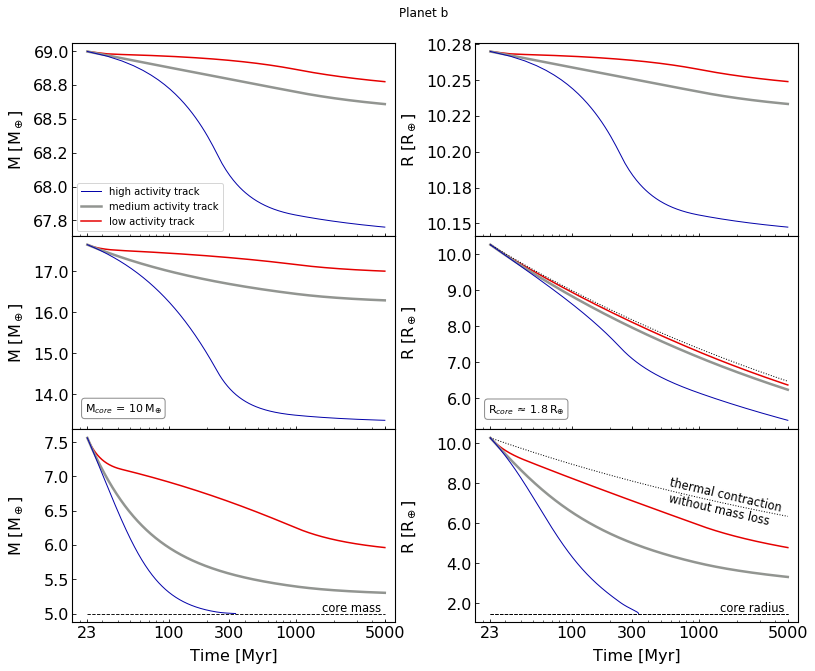

In [16]:
fig, axs = plt.subplots(3,2, figsize=(13,10), sharex=True, sharey=False)
fig.suptitle("Planet b")
fig.subplots_adjust(top=0.93)

# Otegi/heavy
axs[0, 0].plot(t3_b_Ot, M3_b_Ot, label="high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t1_b_Ot, M1_b_Ot, label="medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 0].plot(t2_b_Ot, M2_b_Ot, label="low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 0].plot(t3_b_10, M3_b_10, ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t1_b_10, M1_b_10, ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 0].plot(t2_b_10, M2_b_10, ls="-", color="xkcd:red", lw=1.5, zorder=1)
#axs[1, 0].hlines(M_core10, t3_b_10[0], 5000., ls="--", color="k", lw=0.9)
#axs[1, 0].text(25, 10.025, "core mass", fontsize=11.5)

# 5Mcore
axs[2, 0].plot(t3_b_5, M3_b_5, ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t1_b_5, M1_b_5, ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 0].plot(t2_b_5, M2_b_5, ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 0].hlines(pl_b_5.core_mass, t3_b_5[0], 5000., linestyle="--", color="k", lw=0.9)
axs[2, 0].text(1600, 5.03, "core mass", fontsize=11.5)

#radii
# Otegi/heavy
axs[0, 1].plot(t3_b_Ot, R3_b_Ot, ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t1_b_Ot, R1_b_Ot, ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 1].plot(t2_b_Ot, R2_b_Ot, ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 1].plot(t3_b_10, R3_b_10, ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t1_b_10, R1_b_10, ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 1].plot(t2_b_10, R2_b_10, ls="-", color="xkcd:red", lw=1.5, zorder=1)
age_arr = np.linspace(23., 5000., 1000)
axs[1, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_b_10.core_mass, pl_b_10.fenv, age_arr, pl_b_10.flux, pl_b_10.metallicity), color="k", ls=":", lw=1)

# 5 mcore
axs[2, 1].plot(t3_b_5, R3_b_5, ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t1_b_5, R1_b_5, ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 1].plot(t2_b_5, R2_b_5, ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_b_5.core_mass, pl_b_5.fenv, age_arr, pl_b_5.flux, pl_b_5.metallicity), color="k", ls=":", lw=1)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_b_5.core_mass), pl_b_5.age, 5000., linestyle="--", color="k", lw=0.9)
dy = 4.27
axs[2, 1].text(575, 3.6+dy, "thermal contraction", fontsize=11.5, rotation=-13)
axs[2, 1].text(570, 2.8+dy, "without mass loss", fontsize=11.5, rotation=-13)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_b_5.core_mass), t3_b_5[0], 5000., linestyle="--", color="k", lw=0.9)
axs[2, 1].text(1475, 1.62, "core radius", fontsize=11.5)

# box with core & radius for 10Mcore planet
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
axs[1, 0].text(22, 13.65, r"M$_{core}\,=\,10\,$M$_{\oplus}$", va="center", size=11, bbox=bbox_props)
axs[1, 1].text(22, 5.7, r"R$_{core}\,\approx\,1.8\,$R$_{\oplus}$", va="center", size=11, bbox=bbox_props)

axs[0, 0].legend(fontsize=10, loc=3)
for ax in [axs[0, 0], axs[1, 0], axs[2, 0]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('M [M$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

for ax in [axs[0, 1], axs[1, 1], axs[2, 1]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('R [R$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places
    
axs[0,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f')) # No decimal places
plt.subplots_adjust(hspace=0, wspace=0.25)
fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])
#plt.tight_layout()
#plt.savefig("./Plots_PAPER/planet_b_EVO_eps01.jpg", dpi=300)
plt.show()

## Plot mass & radius evolution planet e

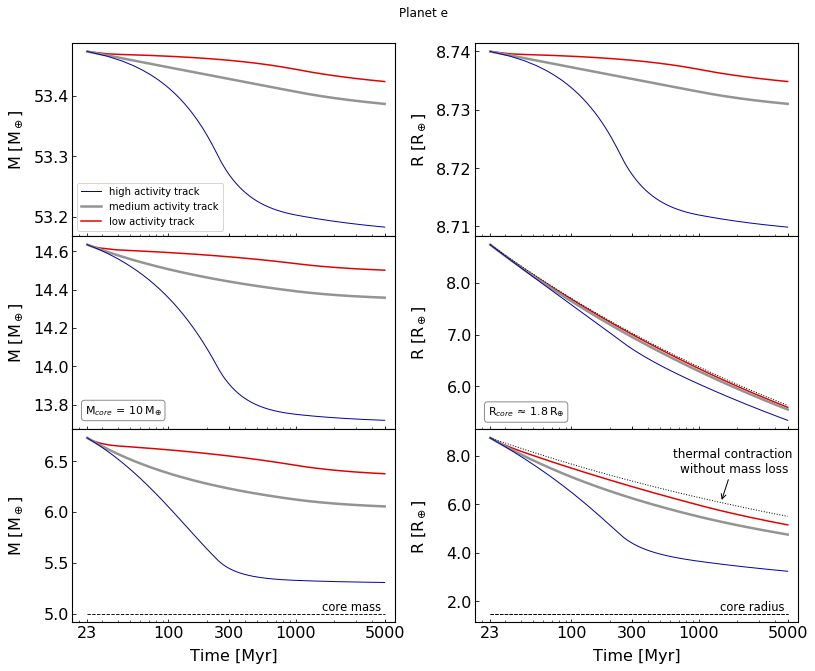

In [17]:
fig, axs = plt.subplots(3,2, figsize=(13,10), sharex=True, sharey=False)
fig.suptitle("Planet e")
fig.subplots_adjust(top=0.93)

# Otegi/heavy
axs[0, 0].plot(t3_e_Ot, M3_e_Ot, label="high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t1_e_Ot, M1_e_Ot, label="medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 0].plot(t2_e_Ot, M2_e_Ot, label="low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 0].plot(t3_e_10, M3_e_10, ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t1_e_10, M1_e_10, ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 0].plot(t2_e_10, M2_e_10, ls="-", color="xkcd:red", lw=1.5, zorder=1)
#axs[1, 0].hlines(M_core10/MEc, t3_e_10[0], 5000., ls="--", color="k", lw=0.9)
#axs[1, 0].text(25, 10.025, "core mass", fontsize=11.5)

# 5Mcore
axs[2, 0].plot(t3_e_5, M3_e_5, ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t1_e_5, M1_e_5, ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 0].plot(t2_e_5, M2_e_5, ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 0].hlines(pl_e_5.core_mass, t3_e_5[0], 5000., linestyle="--", color="k", lw=0.9)
axs[2, 0].text(1600, 5.03, "core mass", fontsize=11.5)

#radii
# Otegi/heavy
axs[0, 1].plot(t3_e_Ot, R3_e_Ot, ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t1_e_Ot, R1_e_Ot, ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 1].plot(t2_e_Ot, R2_e_Ot, ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 1].plot(t3_e_10, R3_e_10, ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t1_e_10, R1_e_10, ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 1].plot(t2_e_10, R2_e_10, ls="-", color="xkcd:red", lw=1.5, zorder=1)
age_arr = np.linspace(23., 5000., 1000)
axs[1, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_e_10.core_mass, pl_e_10.fenv, age_arr, pl_e_10.flux, pl_e_10.metallicity), color="k", ls=":", lw=1)

# 5 mcore
axs[2, 1].plot(t3_e_5, R3_e_5, ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t1_e_5, R1_e_5, ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 1].plot(t2_e_5, R2_e_5, ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_e_5.core_mass, pl_e_5.fenv, age_arr, pl_e_5.flux, pl_e_5.metallicity), color="k", ls=":", lw=1)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_e_5.core_mass), pl_e_5.age, 5000., linestyle="--", color="k", lw=0.9)
dy = 2.6
axs[2, 1].annotate('thermal contraction \nwithout mass loss', xy=(1500, 3.5+dy), xytext=(1900, 7.3), fontsize=12, ha='center',
            arrowprops=dict(arrowstyle="->"))
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_e_5.core_mass), t3_e_5[0], 5000., linestyle="--", color="k", lw=0.9)
axs[2, 1].text(1475, 1.62, "core radius", fontsize=11.5)

# box with core & radius for 10Mcore planet
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
axs[1, 0].text(22, 13.77, r"M$_{core}\,=\,10\,$M$_{\oplus}$", va="center", size=11, bbox=bbox_props)
axs[1, 1].text(22, 5.5, r"R$_{core}\,\approx\,1.8\,$R$_{\oplus}$", va="center", size=11, bbox=bbox_props)

axs[0, 0].legend(fontsize=10, loc=3)
for ax in [axs[0, 0], axs[1, 0], axs[2, 0]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('M [M$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places
    
for ax in [axs[0, 1], axs[1, 1], axs[2, 1]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('R [R$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places
    
axs[0,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f')) # No decimal places
plt.subplots_adjust(hspace=0, wspace=0.25)
fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])
#plt.tight_layout()
#plt.savefig("./Plots_PAPER/planet_e_EVO_eps01.jpg", dpi=300)
plt.show()

## Evolution of planets in the Radius-Period diagram

### Get data from exoplanet.eu

In [18]:
# Instantiate exoplanetEU2 object (download all the planets)
v = pyasl.ExoplanetEU2()
# Export all data as a pandas DataFrame
planets = v.getAllDataPandas()
planets_masses = planets[~np.isnan(planets["mass"])]

mask_nan = ~(np.isnan(planets["orbital_period"]) | np.isnan(planets["radius"]))
mask_P = planets["orbital_period"]<300
planets_ = planets[mask_nan & mask_P] # dataframe only with planets which have P & R

R_to_earth = 11.2
period = planets_["orbital_period"].values
radius = planets_["radius"].values*R_to_earth
ds = planets_["semi_major_axis"].values

# Gaussian kernel density estimation
# actual data -> transform to log space
log3P = np.log(period)/np.log(3)
log2R = np.log(radius)/np.log(2)

# make a grid (in log space - to match the data)
n = np.arange(log3P.min(),log3P.max()+1,1)
m = np.arange(log2R.min(),log2R.max()+1,1)
nn, mm = np.mgrid[n.min():n.max():200j, m.min():m.max():200j] 

nm_sample = np.vstack([nn.ravel(), mm.ravel()]).T # now I have a grid of points covering my radii and periods
nm_train  = np.vstack([log3P, log2R]).T # this is my data in grid-form

# construct a Gaussian kernel density estimate of the distribution
kde = KernelDensity(bandwidth=0.25, kernel='gaussian')
kde.fit(nm_train) # fit/load real dataset

# score_samples() returns the log-likelihood of the samples
prob_density = np.exp(kde.score_samples(nm_sample))
# nm_sample is the range/grid over which I compute the density based on the data (2-D)
prob_density = np.reshape(prob_density, nn.shape)

### Get final radii from simulation

`read_in_PLATYPOS_results_dataframe` extracts the final radius from each track and stores it in a dataframe together with all initial parameters

In [19]:
# read in initial and final parameters as dataframe
pl_all_df_5, tracks_dict = read_in_PLATYPOS_results_dataframe(path_to_results="results_LoFo14_Mcore5_varstep/", N_tracks=3)
pl_all_df_10, tracks_dict = read_in_PLATYPOS_results_dataframe(path_to_results="results_LoFo14_Mcore10_varstep/", N_tracks=3)
pl_all_df_Ot, tracks_dict = read_in_PLATYPOS_results_dataframe(path_to_results="results_Ot20_varstep/", N_tracks=3)

# store final radii in variables (3 - high activity, 1 - medium activity, 2 - low activity)
R3_c_5f, R1_c_5f, R2_c_5f = pl_all_df_5.loc["planet_1"]["R3"], pl_all_df_5.loc["planet_1"]["R1"], pl_all_df_5.loc["planet_1"]["R2"]
R3_d_5f, R1_d_5f, R2_d_5f = pl_all_df_5.loc["planet_2"]["R3"], pl_all_df_5.loc["planet_2"]["R1"], pl_all_df_5.loc["planet_2"]["R2"]
R3_b_5f, R1_b_5f, R2_b_5f = pl_all_df_5.loc["planet_3"]["R3"], pl_all_df_5.loc["planet_3"]["R1"], pl_all_df_5.loc["planet_3"]["R2"]
R3_e_5f, R1_e_5f, R2_e_5f = pl_all_df_5.loc["planet_4"]["R3"], pl_all_df_5.loc["planet_4"]["R1"], pl_all_df_5.loc["planet_4"]["R2"]

R3_c_10f, R1_c_10f, R2_c_10f = pl_all_df_10.loc["planet_1"]["R3"], pl_all_df_10.loc["planet_1"]["R1"], pl_all_df_10.loc["planet_1"]["R2"]
R3_d_10f, R1_d_10f, R2_d_10f = pl_all_df_10.loc["planet_2"]["R3"], pl_all_df_10.loc["planet_2"]["R1"], pl_all_df_10.loc["planet_2"]["R2"]
R3_b_10f, R1_b_10f, R2_b_10f = pl_all_df_10.loc["planet_3"]["R3"], pl_all_df_10.loc["planet_3"]["R1"], pl_all_df_10.loc["planet_3"]["R2"]
R3_e_10f, R1_e_10f, R2_e_10f = pl_all_df_10.loc["planet_4"]["R3"], pl_all_df_10.loc["planet_4"]["R1"], pl_all_df_10.loc["planet_4"]["R2"]

R3_c_Otf, R1_c_Otf, R2_c_Otf = pl_all_df_Ot.loc["planet_1"]["R3"], pl_all_df_Ot.loc["planet_1"]["R1"], pl_all_df_Ot.loc["planet_1"]["R2"]
R3_d_Otf, R1_d_Otf, R2_d_Otf = pl_all_df_Ot.loc["planet_2"]["R3"], pl_all_df_Ot.loc["planet_2"]["R1"], pl_all_df_Ot.loc["planet_2"]["R2"]
R3_b_Otf, R1_b_Otf, R2_b_Otf = pl_all_df_Ot.loc["planet_3"]["R3"], pl_all_df_Ot.loc["planet_3"]["R1"], pl_all_df_Ot.loc["planet_3"]["R2"]
R3_e_Otf, R1_e_Otf, R3_e_Otf = pl_all_df_Ot.loc["planet_4"]["R3"], pl_all_df_Ot.loc["planet_4"]["R1"], pl_all_df_Ot.loc["planet_4"]["R2"]

Total # of planet folders =  4
Non-empty folders:  4

Total number of planets to analyze:  4
Total # of planet folders =  4
Non-empty folders:  4

Total number of planets to analyze:  4
Total # of planet folders =  4
Non-empty folders:  4

Total number of planets to analyze:  4


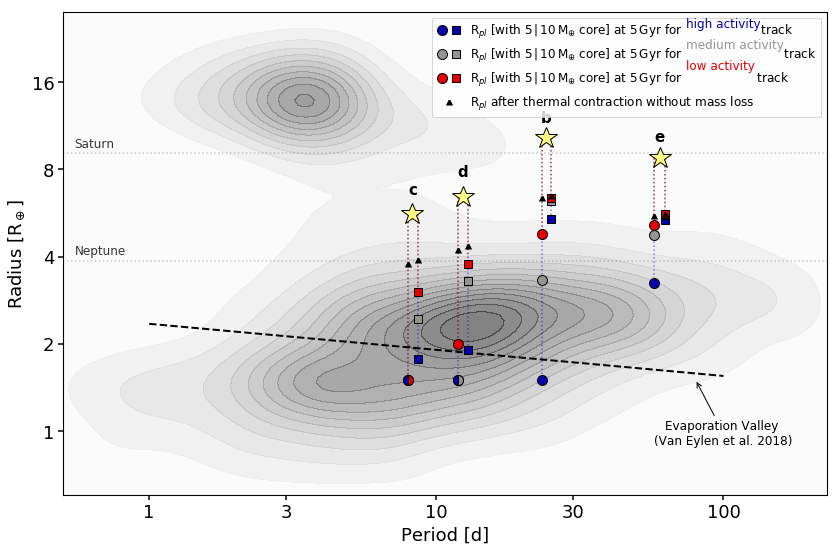

In [20]:
# NOTE: in the notebook the legend looks funny/misaligned, but in the saved figure eveything aligns correctly.

matplotlib.rcParams.update({'font.size': 18, 'legend.fontsize': 14, 'axes.linewidth':1.1})
fig, ax = plt.subplots(figsize=(12,8))
# plot gaussian kernel density of known exoplanet population
ax.contourf(3**nn, 2**mm, prob_density, cmap="binary", levels=15, alpha=0.5)
#plt.plot(log3P, log2R, marker=".", ls="None", alpha=0.1, c="r") # actual data points (before smoothing)

#period-radius evaporation valley (van Eylen)
ax.plot(np.linspace(1,100,100), 10**(-0.09*np.log10(np.linspace(1,100,100))+0.37), linestyle='--', lw=2, color='xkcd:black', label='Evaporation valley \n(Van Eylen et al. 2018)')
ax.annotate('Evaporation Valley \n(Van Eylen et al. 2018)', xy=(80, 1.5), xytext=(100, 0.9), fontsize=12, ha='center',
            arrowprops=dict(arrowstyle="->"))

ax.plot(P_c, R_c, marker="*", color="xkcd:pale yellow", mec="black", ms=23)
ax.plot(P_d, R_d, marker="*", color="xkcd:pale yellow", mec="black", ms=23)
ax.plot(P_b, R_b, marker="*", color="xkcd:pale yellow", mec="black", ms=23)
ax.plot(P_e, R_e, marker="*", color="xkcd:pale yellow", mec="black", ms=23)

# plot planetary evolution tracks
# draw mark where final radius after thermal contraction without mass loss is as black triangle!
######################################################################################################################################
mspp = 4 # marker size of thermal evo marker
mspp_5 = 10 # marker size of planet positions (5coremass)
mspp_10 = 8 # marker size of planet positions (5coremass)

# planet c
# M_core = 5
dP = 0.3
ax.plot(P_c-dP, R3_c_5f, color="xkcd:royal blue", alpha=1, marker="o", ms=mspp_5, mew=1, mec="xkcd:black")
ax.vlines(P_c-dP, R_c, R3_c_5f, color="xkcd:royal blue", linestyle=":", alpha=0.5)
#ax.plot(P_c-dP, R1_c_5f, color="xkcd:grey", alpha=1, marker="o", ms=mspp_5, mew=1, mec="xkcd:black", fillstyle="left")
ax.plot(P_c-dP, R2_c_5f, color="xkcd:red", alpha=1, marker="o", ms=mspp_5, mew=1, mec="xkcd:black", fillstyle="right")
ax.vlines(P_c-dP, R_c, R2_c_5f, color="xkcd:red", linestyle=":", alpha=0.5)
# final radius with thermal contraction only
ax.plot(P_c-dP, plmo14.calculate_planet_radius(pl_c_5.core_mass, pl_c_5.fenv, 5000., pl_c_5.flux, pl_c_5.metallicity), 
        color="xkcd:black", ls="None", marker="^", ms=mspp, mew=2, mec="xkcd:black", alpha=1)

dP = -0.35
ax.plot(P_c-dP, R3_c_10f, color="xkcd:royal blue", alpha=1, marker="s", ms=mspp_10, mew=1, mec="xkcd:black")
ax.vlines(P_c-dP, R_c, R3_c_10f, color="xkcd:royal blue", linestyle=":", alpha=0.5)
ax.plot(P_c-dP, R1_c_10f, color="xkcd:grey", alpha=1, marker="s", ms=mspp_10, mew=1, mec="xkcd:black")
ax.plot(P_c-dP, R2_c_10f, color="xkcd:red", alpha=1, marker="s", ms=mspp_10, mew=1, mec="xkcd:black")
ax.vlines(P_c-dP, R_c, R2_c_10f, color="xkcd:red", linestyle=":", alpha=0.5)
ax.plot(P_c-dP, plmo14.calculate_planet_radius(pl_c_10.core_mass, pl_c_10.fenv,  5000., pl_c_10.flux, pl_c_10.metallicity), 
        color="xkcd:black", ls="None", marker="^", ms=mspp, mew=2, mec="xkcd:black", alpha=1)

######################################################################################################################################
# planet d
# M_core = 5
dP = 0.5
ax.plot(P_d-dP, R3_d_5f, color="xkcd:royal blue", alpha=1, marker="o", ms=mspp_5, mew=1, mec="xkcd:black")
ax.vlines(P_d-dP, R_d, R3_d_5f, color="xkcd:royal blue", linestyle=":", alpha=0.5)
ax.plot(P_d-dP, R1_d_5f, color="xkcd:grey", alpha=1, marker="o", ms=mspp_5, mew=1, mec="xkcd:black", fillstyle="right")
ax.plot(P_d-dP, R2_d_5f, color="xkcd:red", alpha=1, marker="o", ms=mspp_5, mew=1, mec="xkcd:black")
ax.vlines(P_d-dP, R_d, R2_d_5f, color="xkcd:red", linestyle=":", alpha=0.5)  
ax.plot(P_d-dP, plmo14.calculate_planet_radius(pl_d_5.core_mass, pl_d_5.fenv, 5000., pl_d_5.flux, pl_d_5.metallicity), 
        color="xkcd:black", ls="None", marker="^", ms=mspp, mew=2, mec="xkcd:black", alpha=1)

dP = -0.5
ax.plot(P_d-dP, R3_d_10f, color="xkcd:royal blue", alpha=1, marker="s", ms=mspp_10, mew=1, mec="xkcd:black")
ax.vlines(P_d-dP, R_d, R3_d_10f, color="xkcd:royal blue", linestyle=":", alpha=0.5)
ax.plot(P_d-dP, R1_d_10f, color="xkcd:grey", alpha=1, marker="s", ms=mspp_10, mew=1, mec="xkcd:black")
ax.plot(P_d-dP, R2_d_10f, color="xkcd:red", alpha=1, marker="s", ms=mspp_10, mew=1, mec="xkcd:black")
ax.vlines(P_d-dP, R_d, R2_d_10f, color="xkcd:red", linestyle=":", alpha=0.5)
ax.plot(P_d-dP, plmo14.calculate_planet_radius(pl_d_10.core_mass, pl_d_10.fenv,  5000., pl_d_10.flux, pl_d_10.metallicity), 
        color="xkcd:black", ls="None", marker="^", ms=mspp, mew=2, mec="xkcd:black", alpha=1)

######################################################################################################################################
# planet b
# M_core = 5
dP = 0.85
ax.plot(P_b-dP, R3_b_5f, color="xkcd:royal blue", alpha=1, marker="o", ms=mspp_5, mew=1, mec="xkcd:black")
ax.vlines(P_b-dP, R_b, R3_b_5f, color="xkcd:royal blue", linestyle=":", alpha=0.5)
ax.plot(P_b-dP, R1_b_5f, color="xkcd:grey", alpha=1, marker="o", ms=mspp_5, mew=1, mec="xkcd:black")
ax.plot(P_b-dP, R2_b_5f, color="xkcd:red", alpha=1, marker="o", ms=mspp_5, mew=1, mec="xkcd:black")
ax.vlines(P_b-dP, R_b, R2_b_5f, color="xkcd:red", linestyle=":", alpha=0.5)
ax.plot(P_b-dP, plmo14.calculate_planet_radius(pl_b_5.core_mass, pl_b_5.fenv, 5000., pl_b_5.flux, pl_b_5.metallicity), 
        color="xkcd:black", ls="None", marker="^", ms=mspp, mew=2, mec="xkcd:black", alpha=1)

# M_core = 10
dP = -0.85
ax.plot(P_b-dP, R3_b_10f, color="xkcd:royal blue", alpha=1, marker="s", ms=mspp_10, mew=1, mec="xkcd:black")#marker="x", markersize=10, fillstyle="none", markeredgewidth=2.5)
ax.vlines(P_b-dP, R_b, R3_b_10f, color="xkcd:royal blue", linestyle=":", alpha=0.5)
ax.plot(P_b-dP, R1_b_10f, color="xkcd:grey", alpha=1, marker="s", ms=mspp_10, mew=1, mec="xkcd:black")
ax.plot(P_b-dP, R2_b_10f, color="xkcd:red", alpha=1, marker="s", ms=mspp_10, mew=1, mec="xkcd:black")#marker="x", markersize=10, fillstyle="none", markeredgewidth=2.5)
ax.vlines(P_b-dP, R_b, R2_b_10f, color="xkcd:red", linestyle=":", alpha=0.5)
ax.plot(P_b-dP, plmo14.calculate_planet_radius(pl_b_10.core_mass, pl_b_10.fenv,  5000., pl_b_10.flux, pl_b_10.metallicity), 
        color="xkcd:black", ls="None", marker="^", ms=mspp, mew=2, mec="xkcd:black", alpha=1)

######################################################################################################################################
# planet e
# M_core = 5
dP = 2.5
p1, = ax.plot(P_e-dP, R3_e_5f, color="xkcd:royal blue", alpha=1, marker="o", ms=mspp_5, mew=1, mec="xkcd:black", ls="None")#marker="x", markersize=10, fillstyle="none", markeredgewidth=2.5)
ax.vlines(P_e-dP, R_e, R3_e_5f, color="xkcd:royal blue", linestyle=":", alpha=0.5)
p6, = ax.plot(P_e-dP, R1_e_5f, color="xkcd:grey", alpha=1, marker="o", ms=mspp_5, mew=1, mec="xkcd:black", ls="None")
p3, = ax.plot(P_e-dP, R2_e_5f, color="xkcd:red", alpha=1, marker="o", ms=mspp_5, mew=1, mec="xkcd:black", ls="None")#marker="x", markersize=10, fillstyle="none", markeredgewidth=2.5)
ax.vlines(P_e-dP, R_e, R2_e_5f, color="xkcd:red", linestyle=":", alpha=0.5)
ax.plot(P_e-dP, plmo14.calculate_planet_radius(pl_e_5.core_mass, pl_e_5.fenv, 5000., pl_e_5.flux, pl_e_5.metallicity), 
        color="xkcd:black", ls="None", marker="^", ms=mspp, mew=2, mec="xkcd:black", alpha=1)

# M_core = 10
dP = -2.5
p2, = ax.plot(P_e-dP, R3_e_10f, color="xkcd:royal blue", alpha=1, marker="s", ms=mspp_10, mew=1, mec="xkcd:black", ls="None")#marker="x", markersize=10, fillstyle="none", markeredgewidth=2.5)
ax.vlines(P_e-dP, R_e, R3_e_10f, color="xkcd:royal blue", linestyle=":", alpha=0.5)
p7, = ax.plot(P_e-dP, R1_e_10f, color="xkcd:grey", alpha=1, marker="s", ms=mspp_10, mew=1, mec="xkcd:black", ls="None")
p4, = ax.plot(P_e-dP, R2_e_10f, color="xkcd:red", alpha=1, marker="s", ms=mspp_10, mew=1, mec="xkcd:black", ls="None")#marker="x", markersize=10, fillstyle="none", markeredgewidth=2.5)
ax.vlines(P_e-dP, R_e, R2_e_10f, color="xkcd:red", linestyle=":", alpha=0.5)
p5, = ax.plot(P_e-dP, plmo14.calculate_planet_radius(pl_e_10.core_mass, pl_e_10.fenv,  5000., pl_e_10.flux, pl_e_10.metallicity), 
        color="xkcd:black", ls="None", marker="^", ms=mspp, mew=2, mec="xkcd:black", alpha=1)

######################################################################################################################################
# custom legend markers
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

leg1 = ax.legend([(p1, p2), (p6, p7), (p3, p4), p5], 
                 ['R$_{pl}$ [with $5\,|\,10\,$M$_{\oplus}$ core] at $5\,$Gyr for '+'  \t\t '+' track', 
                  'R$_{pl}$ [with $5\,|\,10\,$M$_{\oplus}$ core] at $5\,$Gyr for '+'  \t\t\t'+'track', 
                  'R$_{pl}$ [with $5\,|\,10\,$M$_{\oplus}$ core] at $5\,$Gyr for '+'  \t\t '+'track', 
                  "R$_{pl}$ after thermal contraction without mass loss"], 
          scatterpoints=1, numpoints=1, handler_map={tuple: HandlerTuple(ndivide=None)}, fontsize=12, loc='upper right')


ybox1 = TextArea("high activity", textprops=dict(color="xkcd:royal blue", size=12,rotation=0, ha='left',va='bottom'))
ybox2 = TextArea("medium activity", textprops=dict(color="xkcd:grey", size=12,rotation=0, ha='left',va='bottom'))
ybox3 = TextArea("low activity", textprops=dict(color="xkcd:red", size=12,rotation=0, ha='left',va='bottom'))
ybox = VPacker(children=[ybox1, ybox2, ybox3], align="left", pad=0.5, sep=8)

anchored_ybox = AnchoredOffsetbox(child=ybox, pad=0., frameon=False, 
                                  bbox_transform=ax.transAxes, borderpad=0., bbox_to_anchor=[0.815, 0.868], loc=3)
ax.add_artist(anchored_ybox)
anchored_ybox.zorder = 20

################################################################
ax.loglog(basey=2, basex=3)
ax.set_xlim(0.5, 230)
ax.set_ylim(0.6, 28)

# plot some radius lines for reference (Neptune and Saturn)
xlim = ax.get_xlim()
R_J = (69911*1e5)/const.R_earth.cgs.value
R_S = (58232*1e5)/const.R_earth.cgs.value
R_N = (24622*1e5)/const.R_earth.cgs.value
ax.hlines(R_N, xlim[0], xlim[1], linestyle=":", alpha=0.25, color="xkcd:dark grey")
ax.hlines(R_S, xlim[0], xlim[1], linestyle=":", alpha=0.25, color="xkcd:dark grey")
dx = 0.05
dy = 0.15
#ax.text(xlim[0]+dx, 1.+0.05, "Earth", fontsize=15, color="xkcd:dark grey")
ax.text(xlim[0]+dx, R_N+0.2, "Neptune", fontsize=12, color="xkcd:dark grey")
ax.text(xlim[0]+dx, R_S+0.4, "Saturn", fontsize=12, color="xkcd:dark grey")

#plot line for core radius
#ax.hlines(5**0.25, xlim[0], xlim[1], linestyle=":", alpha=0.4, color="xkcd:dark grey", lw=3) 
#ax.hlines(10**0.25, xlim[0], xlim[1], linestyle=":", alpha=0.4, color="xkcd:dark grey", lw=3)

ax.text(P_c, R_c+1.2, "c", fontsize=15, horizontalalignment='center', verticalalignment='center', weight="bold")
ax.text(P_d, R_d+1.4, "d", fontsize=15, horizontalalignment='center', verticalalignment='center', weight="bold")
ax.text(P_b, R_b+1.8, "b", fontsize=15, horizontalalignment='center', verticalalignment='center', weight="bold")
ax.text(P_e, R_e+1.6, "e", fontsize=15, horizontalalignment='center', verticalalignment='center', weight="bold")

from matplotlib.ticker import FixedLocator, FixedFormatter
x_formatter = FixedFormatter([1,3,10,30,100,300])
y_formatter = FixedFormatter([1,2,4,8,16])
x_locator = FixedLocator([1,3,10,30,100])
y_locator = FixedLocator([1,2,4,8,16])
ax.xaxis.set_major_formatter(x_formatter)
ax.yaxis.set_major_formatter(y_formatter)
ax.xaxis.set_major_locator(x_locator)
ax.yaxis.set_major_locator(y_locator)
#ax.xaxis.grid(True, which='minor')
ax.tick_params(which='minor', length=0)
ax.tick_params(which='major', width=1.5, length=5)

#ax.legend(fontsize=12)
ax.set_ylabel("Radius [R$_\oplus$]")
ax.set_xlabel("Period [d]")
plt.tight_layout()
#plt.savefig("./Plots_PAPER/Fluffy_Planet_Scenario_radius_period_diagram_solarZ.jpeg", dpi=300)
plt.show()

*****
# Influence of errors on $L_x$ - evolve planets with lower & upper Lx

## LoFo14 - Mcore5

In [21]:
%%time
folder_name = "results_LoFo14_Mcore5_lowerLx_varstep/"
path_save, planet_chunks = create_planet_chunks(curr_path, folder_name=folder_name, list_planets=planet_list_Mcore5, chunk_size=4)
eps, init_step, t_final = 0.1, 0.1, 5000.

# this is where the mulit-processing happens
if __name__ == "__main__":
    evolve_ensamble(planet_chunks, t_final, initial_step_size=init_step, epsilon=eps, 
                    K_on="yes", beta_on="yes", evo_track_dict_list=list_tracks_lower, path_save=path_save)
    
# read in the results as a dataframe
pl_LoFo14_Mcore5l_dict, pl_LoFo14_Mcore5l_init_df, tracks_LoFo14_Mcore5l_dict = read_in_PLATYPOS_results(path_to_results="./results_LoFo14_Mcore5_lowerLx_varstep/", N_tracks=3)

folder_name = "results_LoFo14_Mcore5_upperLx_varstep/"
path_save, planet_chunks = create_planet_chunks(curr_path, folder_name=folder_name, list_planets=planet_list_Mcore5, chunk_size=4)
eps, init_step, t_final = 0.1, 0.1, 5000.

# this is where the mulit-processing happens
if __name__ == "__main__":
    evolve_ensamble(planet_chunks, t_final, initial_step_size=init_step, epsilon=eps, 
                    K_on="yes", beta_on="yes", evo_track_dict_list=list_tracks_upper, path_save=path_save)
    
# read in the results as a dataframe
pl_LoFo14_Mcore5u_dict, pl_LoFo14_Mcore5u_init_df, tracks_LoFo14_Mcore5u_dict = read_in_PLATYPOS_results(path_to_results="./results_LoFo14_Mcore5_upperLx_varstep/", N_tracks=3)

Folder -> results_LoFo14_Mcore5_lowerLx_varstep/ <- exists.
start
That took 0.0007675766944885253 minutes
Total # of planet folders =  4
Non-empty folders:  4

Total number of planets to analyze:  4
Folder -> results_LoFo14_Mcore5_upperLx_varstep/ <- exists.
start
That took 0.0008884946505228679 minutes
Total # of planet folders =  4
Non-empty folders:  4

Total number of planets to analyze:  4
CPU times: user 160 ms, sys: 64.1 ms, total: 224 ms
Wall time: 260 ms


## LoFo14 - Mcore10

In [22]:
%%time
folder_name = "results_LoFo14_Mcore10_lowerLx_varstep/"
path_save, planet_chunks = create_planet_chunks(curr_path, folder_name=folder_name, list_planets=planet_list_Mcore10, chunk_size=4)
eps, init_step, t_final = 0.1, 0.1, 5000.

# this is where the mulit-processing happens
if __name__ == "__main__":
    evolve_ensamble(planet_chunks, t_final, initial_step_size=init_step, epsilon=eps, 
                    K_on="yes", beta_on="yes", evo_track_dict_list=list_tracks_lower, path_save=path_save)
    
# read in the results as a dataframe
pl_LoFo14_Mcore10l_dict, pl_LoFo14_Mcore10l_init_df, tracks_LoFo14_Mcore10l_dict = read_in_PLATYPOS_results(path_to_results="./results_LoFo14_Mcore10_lowerLx_varstep/", N_tracks=3)

folder_name = "results_LoFo14_Mcore10_upperLx_varstep/"
path_save, planet_chunks = create_planet_chunks(curr_path, folder_name=folder_name, list_planets=planet_list_Mcore10, chunk_size=4)
eps, init_step, t_final = 0.1, 0.1, 5000.

# this is where the mulit-processing happens
if __name__ == "__main__":
    evolve_ensamble(planet_chunks, t_final, initial_step_size=init_step, epsilon=eps, 
                    K_on="yes", beta_on="yes", evo_track_dict_list=list_tracks_upper, path_save=path_save)
    
# read in the results as a dataframe
pl_LoFo14_Mcore10u_dict, pl_LoFo14_Mcore10u_init_df, tracks_LoFo14_Mcore10u_dict = read_in_PLATYPOS_results(path_to_results="./results_LoFo14_Mcore10_upperLx_varstep/", N_tracks=3)

Folder -> results_LoFo14_Mcore10_lowerLx_varstep/ <- exists.
start
That took 0.000849612553914388 minutes
Total # of planet folders =  4
Non-empty folders:  4

Total number of planets to analyze:  4
Folder -> results_LoFo14_Mcore10_upperLx_varstep/ <- exists.
start
That took 0.0006582736968994141 minutes
Total # of planet folders =  4
Non-empty folders:  4

Total number of planets to analyze:  4
CPU times: user 144 ms, sys: 60.2 ms, total: 204 ms
Wall time: 233 ms


## Ot20 

In [23]:
%%time
folder_name = "results_Ot20_lowerLx_varstep/"
path_save, planet_chunks = create_planet_chunks(curr_path, folder_name=folder_name, list_planets=planet_list_Ot, chunk_size=4)
eps, init_step, t_final = 0.1, 1., 5000.

# this is where the mulit-processing happens
if __name__ == "__main__":
    evolve_ensamble(planet_chunks, t_final, initial_step_size=init_step, epsilon=eps, 
                    K_on="yes", beta_on="yes", evo_track_dict_list=list_tracks_lower, path_save=path_save)
    
# read in the results as a dataframe
pl_Ot20l_dict, pl_Ot20l_init_df, tracks_Ot20l_dict = read_in_PLATYPOS_results(path_to_results="./results_Ot20_lowerLx_varstep/", N_tracks=3)

folder_name = "results_Ot20_upperLx_varstep/"
path_save, planet_chunks = create_planet_chunks(curr_path, folder_name=folder_name, list_planets=planet_list_Ot, chunk_size=4)
eps, init_step, t_final = 0.1, 1., 5000.

# this is where the mulit-processing happens
if __name__ == "__main__":
    evolve_ensamble(planet_chunks, t_final, initial_step_size=init_step, epsilon=eps, 
                    K_on="yes", beta_on="yes", evo_track_dict_list=list_tracks_upper, path_save=path_save)
    
# read in the results as a dataframe
pl_Ot20u_dict, pl_Ot20u_init_df, tracks_Ot20u_dict = read_in_PLATYPOS_results(path_to_results="./results_Ot20_upperLx_varstep/", N_tracks=3)

Folder -> results_Ot20_lowerLx_varstep/ <- exists.
start
That took 0.0006888707478841146 minutes
Total # of planet folders =  4
Non-empty folders:  4

Total number of planets to analyze:  4
Folder -> results_Ot20_upperLx_varstep/ <- exists.
start
That took 0.0006461540857950846 minutes
Total # of planet folders =  4
Non-empty folders:  4

Total number of planets to analyze:  4
CPU times: user 139 ms, sys: 52 ms, total: 191 ms
Wall time: 204 ms


In [24]:
# extract all the results and save as variables (NOTE: here I read in the results from the variable step size calculations)

# upper Lx
# high activity track
t3_c_Otu, M3_c_Otu, R3_c_Otu = pl_Ot20u_dict["planet_1"]["t3"], pl_Ot20u_dict["planet_1"]["M3"], pl_Ot20u_dict["planet_1"]["R3"]
t3_c_10u, M3_c_10u, R3_c_10u = pl_LoFo14_Mcore10u_dict["planet_1"]["t3"], pl_LoFo14_Mcore10u_dict["planet_1"]["M3"], pl_LoFo14_Mcore10u_dict["planet_1"]["R3"]
t3_c_5u, M3_c_5u, R3_c_5u = pl_LoFo14_Mcore5u_dict["planet_1"]["t3"], pl_LoFo14_Mcore5u_dict["planet_1"]["M3"], pl_LoFo14_Mcore5u_dict["planet_1"]["R3"]
t3_d_Otu, M3_d_Otu, R3_d_Otu = pl_Ot20u_dict["planet_2"]["t3"], pl_Ot20u_dict["planet_2"]["M3"], pl_Ot20u_dict["planet_2"]["R3"]
t3_d_10u, M3_d_10u, R3_d_10u = pl_LoFo14_Mcore10u_dict["planet_2"]["t3"], pl_LoFo14_Mcore10u_dict["planet_2"]["M3"], pl_LoFo14_Mcore10u_dict["planet_2"]["R3"]
t3_d_5u, M3_d_5u, R3_d_5u = pl_LoFo14_Mcore5u_dict["planet_2"]["t3"], pl_LoFo14_Mcore5u_dict["planet_2"]["M3"], pl_LoFo14_Mcore5u_dict["planet_2"]["R3"]
t3_b_Otu, M3_b_Otu, R3_b_Otu = pl_Ot20u_dict["planet_3"]["t3"], pl_Ot20u_dict["planet_3"]["M3"], pl_Ot20u_dict["planet_3"]["R3"]
t3_b_10u, M3_b_10u, R3_b_10u = pl_LoFo14_Mcore10u_dict["planet_3"]["t3"], pl_LoFo14_Mcore10u_dict["planet_3"]["M3"], pl_LoFo14_Mcore10u_dict["planet_3"]["R3"]
t3_b_5u, M3_b_5u, R3_b_5u = pl_LoFo14_Mcore5u_dict["planet_3"]["t3"], pl_LoFo14_Mcore5u_dict["planet_3"]["M3"], pl_LoFo14_Mcore5u_dict["planet_3"]["R3"]
t3_e_Otu, M3_e_Otu, R3_e_Otu = pl_Ot20u_dict["planet_4"]["t3"], pl_Ot20u_dict["planet_4"]["M3"], pl_Ot20u_dict["planet_4"]["R3"]
t3_e_10u, M3_e_10u, R3_e_10u = pl_LoFo14_Mcore10u_dict["planet_4"]["t3"], pl_LoFo14_Mcore10u_dict["planet_4"]["M3"], pl_LoFo14_Mcore10u_dict["planet_4"]["R3"]
t3_e_5u, M3_e_5u, R3_e_5u = pl_LoFo14_Mcore5u_dict["planet_4"]["t3"], pl_LoFo14_Mcore5u_dict["planet_4"]["M3"], pl_LoFo14_Mcore5u_dict["planet_4"]["R3"]

# medium activity track
t1_c_Otu, M1_c_Otu, R1_c_Otu = pl_Ot20u_dict["planet_1"]["t1"], pl_Ot20u_dict["planet_1"]["M1"], pl_Ot20u_dict["planet_1"]["R1"]
t1_c_10u, M1_c_10u, R1_c_10u = pl_LoFo14_Mcore10u_dict["planet_1"]["t1"], pl_LoFo14_Mcore10u_dict["planet_1"]["M1"], pl_LoFo14_Mcore10u_dict["planet_1"]["R1"]
t1_c_5u, M1_c_5u, R1_c_5u = pl_LoFo14_Mcore5u_dict["planet_1"]["t1"], pl_LoFo14_Mcore5u_dict["planet_1"]["M1"], pl_LoFo14_Mcore5u_dict["planet_1"]["R1"]
t1_d_Otu, M1_d_Otu, R1_d_Otu = pl_Ot20u_dict["planet_2"]["t1"], pl_Ot20u_dict["planet_2"]["M1"], pl_Ot20u_dict["planet_2"]["R1"]
t1_d_10u, M1_d_10u, R1_d_10u = pl_LoFo14_Mcore10u_dict["planet_2"]["t1"], pl_LoFo14_Mcore10u_dict["planet_2"]["M1"], pl_LoFo14_Mcore10u_dict["planet_2"]["R1"]
t1_d_5u, M1_d_5u, R1_d_5u = pl_LoFo14_Mcore5u_dict["planet_2"]["t1"], pl_LoFo14_Mcore5u_dict["planet_2"]["M1"], pl_LoFo14_Mcore5u_dict["planet_2"]["R1"]
t1_b_Otu, M1_b_Otu, R1_b_Otu = pl_Ot20u_dict["planet_3"]["t1"], pl_Ot20u_dict["planet_3"]["M1"], pl_Ot20u_dict["planet_3"]["R1"]
t1_b_10u, M1_b_10u, R1_b_10u = pl_LoFo14_Mcore10u_dict["planet_3"]["t1"], pl_LoFo14_Mcore10u_dict["planet_3"]["M1"], pl_LoFo14_Mcore10u_dict["planet_3"]["R1"]
t1_b_5u, M1_b_5u, R1_b_5u = pl_LoFo14_Mcore5u_dict["planet_3"]["t1"], pl_LoFo14_Mcore5u_dict["planet_3"]["M1"], pl_LoFo14_Mcore5u_dict["planet_3"]["R1"]
t1_e_Otu, M1_e_Otu, R1_e_Otu = pl_Ot20u_dict["planet_4"]["t1"], pl_Ot20u_dict["planet_4"]["M1"], pl_Ot20u_dict["planet_4"]["R1"]
t1_e_10u, M1_e_10u, R1_e_10u = pl_LoFo14_Mcore10u_dict["planet_4"]["t1"], pl_LoFo14_Mcore10u_dict["planet_4"]["M1"], pl_LoFo14_Mcore10u_dict["planet_4"]["R1"]
t1_e_5u, M1_e_5u, R1_e_5u = pl_LoFo14_Mcore5u_dict["planet_4"]["t1"], pl_LoFo14_Mcore5u_dict["planet_4"]["M1"], pl_LoFo14_Mcore5u_dict["planet_4"]["R1"]

# low activity track
t2_c_Otu, M2_c_Otu, R2_c_Otu = pl_Ot20u_dict["planet_1"]["t2"], pl_Ot20u_dict["planet_1"]["M2"], pl_Ot20u_dict["planet_1"]["R2"]
t2_c_10u, M2_c_10u, R2_c_10u = pl_LoFo14_Mcore10u_dict["planet_1"]["t2"], pl_LoFo14_Mcore10u_dict["planet_1"]["M2"], pl_LoFo14_Mcore10u_dict["planet_1"]["R2"]
t2_c_5u, M2_c_5u, R2_c_5u = pl_LoFo14_Mcore5u_dict["planet_1"]["t2"], pl_LoFo14_Mcore5u_dict["planet_1"]["M2"], pl_LoFo14_Mcore5u_dict["planet_1"]["R2"]
t2_d_Otu, M2_d_Otu, R2_d_Otu = pl_Ot20u_dict["planet_2"]["t2"], pl_Ot20u_dict["planet_2"]["M2"], pl_Ot20u_dict["planet_2"]["R2"]
t2_d_10u, M2_d_10u, R2_d_10u = pl_LoFo14_Mcore10u_dict["planet_2"]["t2"], pl_LoFo14_Mcore10u_dict["planet_2"]["M2"], pl_LoFo14_Mcore10u_dict["planet_2"]["R2"]
t2_d_5u, M2_d_5u, R2_d_5u = pl_LoFo14_Mcore5u_dict["planet_2"]["t2"], pl_LoFo14_Mcore5u_dict["planet_2"]["M2"], pl_LoFo14_Mcore5u_dict["planet_2"]["R2"]
t2_b_Otu, M2_b_Otu, R2_b_Otu = pl_Ot20u_dict["planet_3"]["t2"], pl_Ot20u_dict["planet_3"]["M2"], pl_Ot20u_dict["planet_3"]["R2"]
t2_b_10u, M2_b_10u, R2_b_10u = pl_LoFo14_Mcore10u_dict["planet_3"]["t2"], pl_LoFo14_Mcore10u_dict["planet_3"]["M2"], pl_LoFo14_Mcore10u_dict["planet_3"]["R2"]
t2_b_5u, M2_b_5u, R2_b_5u = pl_LoFo14_Mcore5u_dict["planet_3"]["t2"], pl_LoFo14_Mcore5u_dict["planet_3"]["M2"], pl_LoFo14_Mcore5u_dict["planet_3"]["R2"]
t2_e_Otu, M2_e_Otu, R2_e_Otu = pl_Ot20u_dict["planet_4"]["t2"], pl_Ot20u_dict["planet_4"]["M2"], pl_Ot20u_dict["planet_4"]["R2"]
t2_e_10u, M2_e_10u, R2_e_10u = pl_LoFo14_Mcore10u_dict["planet_4"]["t2"], pl_LoFo14_Mcore10u_dict["planet_4"]["M2"], pl_LoFo14_Mcore10u_dict["planet_4"]["R2"]
t2_e_5u, M2_e_5u, R2_e_5u = pl_LoFo14_Mcore5u_dict["planet_4"]["t2"], pl_LoFo14_Mcore5u_dict["planet_4"]["M2"], pl_LoFo14_Mcore5u_dict["planet_4"]["R2"]

# lower Lx
# high activity track
t3_c_Otl, M3_c_Otl, R3_c_Otl = pl_Ot20l_dict["planet_1"]["t3"], pl_Ot20l_dict["planet_1"]["M3"], pl_Ot20l_dict["planet_1"]["R3"]
t3_c_10l, M3_c_10l, R3_c_10l = pl_LoFo14_Mcore10l_dict["planet_1"]["t3"], pl_LoFo14_Mcore10l_dict["planet_1"]["M3"], pl_LoFo14_Mcore10l_dict["planet_1"]["R3"]
t3_c_5l, M3_c_5l, R3_c_5l = pl_LoFo14_Mcore5l_dict["planet_1"]["t3"], pl_LoFo14_Mcore5l_dict["planet_1"]["M3"], pl_LoFo14_Mcore5l_dict["planet_1"]["R3"]
t3_d_Otl, M3_d_Otl, R3_d_Otl = pl_Ot20l_dict["planet_2"]["t3"], pl_Ot20l_dict["planet_2"]["M3"], pl_Ot20l_dict["planet_2"]["R3"]
t3_d_10l, M3_d_10l, R3_d_10l = pl_LoFo14_Mcore10l_dict["planet_2"]["t3"], pl_LoFo14_Mcore10l_dict["planet_2"]["M3"], pl_LoFo14_Mcore10l_dict["planet_2"]["R3"]
t3_d_5l, M3_d_5l, R3_d_5l = pl_LoFo14_Mcore5l_dict["planet_2"]["t3"], pl_LoFo14_Mcore5l_dict["planet_2"]["M3"], pl_LoFo14_Mcore5l_dict["planet_2"]["R3"]
t3_b_Otl, M3_b_Otl, R3_b_Otl = pl_Ot20l_dict["planet_3"]["t3"], pl_Ot20l_dict["planet_3"]["M3"], pl_Ot20l_dict["planet_3"]["R3"]
t3_b_10l, M3_b_10l, R3_b_10l = pl_LoFo14_Mcore10l_dict["planet_3"]["t3"], pl_LoFo14_Mcore10l_dict["planet_3"]["M3"], pl_LoFo14_Mcore10l_dict["planet_3"]["R3"]
t3_b_5l, M3_b_5l, R3_b_5l = pl_LoFo14_Mcore5l_dict["planet_3"]["t3"], pl_LoFo14_Mcore5l_dict["planet_3"]["M3"], pl_LoFo14_Mcore5l_dict["planet_3"]["R3"]
t3_e_Otl, M3_e_Otl, R3_e_Otl = pl_Ot20l_dict["planet_4"]["t3"], pl_Ot20l_dict["planet_4"]["M3"], pl_Ot20l_dict["planet_4"]["R3"]
t3_e_10l, M3_e_10l, R3_e_10l = pl_LoFo14_Mcore10l_dict["planet_4"]["t3"], pl_LoFo14_Mcore10l_dict["planet_4"]["M3"], pl_LoFo14_Mcore10l_dict["planet_4"]["R3"]
t3_e_5l, M3_e_5l, R3_e_5l = pl_LoFo14_Mcore5l_dict["planet_4"]["t3"], pl_LoFo14_Mcore5l_dict["planet_4"]["M3"], pl_LoFo14_Mcore5l_dict["planet_4"]["R3"]

# medium activity track
t1_c_Otl, M1_c_Otl, R1_c_Otl = pl_Ot20l_dict["planet_1"]["t1"], pl_Ot20l_dict["planet_1"]["M1"], pl_Ot20l_dict["planet_1"]["R1"]
t1_c_10l, M1_c_10l, R1_c_10l = pl_LoFo14_Mcore10l_dict["planet_1"]["t1"], pl_LoFo14_Mcore10l_dict["planet_1"]["M1"], pl_LoFo14_Mcore10l_dict["planet_1"]["R1"]
t1_c_5l, M1_c_5l, R1_c_5l = pl_LoFo14_Mcore5l_dict["planet_1"]["t1"], pl_LoFo14_Mcore5l_dict["planet_1"]["M1"], pl_LoFo14_Mcore5l_dict["planet_1"]["R1"]
t1_d_Otl, M1_d_Otl, R1_d_Otl = pl_Ot20l_dict["planet_2"]["t1"], pl_Ot20l_dict["planet_2"]["M1"], pl_Ot20l_dict["planet_2"]["R1"]
t1_d_10l, M1_d_10l, R1_d_10l = pl_LoFo14_Mcore10l_dict["planet_2"]["t1"], pl_LoFo14_Mcore10l_dict["planet_2"]["M1"], pl_LoFo14_Mcore10l_dict["planet_2"]["R1"]
t1_d_5l, M1_d_5l, R1_d_5l = pl_LoFo14_Mcore5l_dict["planet_2"]["t1"], pl_LoFo14_Mcore5l_dict["planet_2"]["M1"], pl_LoFo14_Mcore5l_dict["planet_2"]["R1"]
t1_b_Otl, M1_b_Otl, R1_b_Otl = pl_Ot20l_dict["planet_3"]["t1"], pl_Ot20l_dict["planet_3"]["M1"], pl_Ot20l_dict["planet_3"]["R1"]
t1_b_10l, M1_b_10l, R1_b_10l = pl_LoFo14_Mcore10l_dict["planet_3"]["t1"], pl_LoFo14_Mcore10l_dict["planet_3"]["M1"], pl_LoFo14_Mcore10l_dict["planet_3"]["R1"]
t1_b_5l, M1_b_5l, R1_b_5l = pl_LoFo14_Mcore5l_dict["planet_3"]["t1"], pl_LoFo14_Mcore5l_dict["planet_3"]["M1"], pl_LoFo14_Mcore5l_dict["planet_3"]["R1"]
t1_e_Otl, M1_e_Otl, R1_e_Otl = pl_Ot20l_dict["planet_4"]["t1"], pl_Ot20l_dict["planet_4"]["M1"], pl_Ot20l_dict["planet_4"]["R1"]
t1_e_10l, M1_e_10l, R1_e_10l = pl_LoFo14_Mcore10l_dict["planet_4"]["t1"], pl_LoFo14_Mcore10l_dict["planet_4"]["M1"], pl_LoFo14_Mcore10l_dict["planet_4"]["R1"]
t1_e_5l, M1_e_5l, R1_e_5l = pl_LoFo14_Mcore5l_dict["planet_4"]["t1"], pl_LoFo14_Mcore5l_dict["planet_4"]["M1"], pl_LoFo14_Mcore5l_dict["planet_4"]["R1"]

# low activity track
t2_c_Otl, M2_c_Otl, R2_c_Otl = pl_Ot20l_dict["planet_1"]["t2"], pl_Ot20l_dict["planet_1"]["M2"], pl_Ot20l_dict["planet_1"]["R2"]
t2_c_10l, M2_c_10l, R2_c_10l = pl_LoFo14_Mcore10l_dict["planet_1"]["t2"], pl_LoFo14_Mcore10l_dict["planet_1"]["M2"], pl_LoFo14_Mcore10l_dict["planet_1"]["R2"]
t2_c_5l, M2_c_5l, R2_c_5l = pl_LoFo14_Mcore5l_dict["planet_1"]["t2"], pl_LoFo14_Mcore5l_dict["planet_1"]["M2"], pl_LoFo14_Mcore5l_dict["planet_1"]["R2"]
t2_d_Otl, M2_d_Otl, R2_d_Otl = pl_Ot20l_dict["planet_2"]["t2"], pl_Ot20l_dict["planet_2"]["M2"], pl_Ot20l_dict["planet_2"]["R2"]
t2_d_10l, M2_d_10l, R2_d_10l = pl_LoFo14_Mcore10l_dict["planet_2"]["t2"], pl_LoFo14_Mcore10l_dict["planet_2"]["M2"], pl_LoFo14_Mcore10l_dict["planet_2"]["R2"]
t2_d_5l, M2_d_5l, R2_d_5l = pl_LoFo14_Mcore5l_dict["planet_2"]["t2"], pl_LoFo14_Mcore5l_dict["planet_2"]["M2"], pl_LoFo14_Mcore5l_dict["planet_2"]["R2"]
t2_b_Otl, M2_b_Otl, R2_b_Otl = pl_Ot20l_dict["planet_3"]["t2"], pl_Ot20l_dict["planet_3"]["M2"], pl_Ot20l_dict["planet_3"]["R2"]
t2_b_10l, M2_b_10l, R2_b_10l = pl_LoFo14_Mcore10l_dict["planet_3"]["t2"], pl_LoFo14_Mcore10l_dict["planet_3"]["M2"], pl_LoFo14_Mcore10l_dict["planet_3"]["R2"]
t2_b_5l, M2_b_5l, R2_b_5l = pl_LoFo14_Mcore5l_dict["planet_3"]["t2"], pl_LoFo14_Mcore5l_dict["planet_3"]["M2"], pl_LoFo14_Mcore5l_dict["planet_3"]["R2"]
t2_e_Otl, M2_e_Otl, R2_e_Otl = pl_Ot20l_dict["planet_4"]["t2"], pl_Ot20l_dict["planet_4"]["M2"], pl_Ot20l_dict["planet_4"]["R2"]
t2_e_10l, M2_e_10l, R2_e_10l = pl_LoFo14_Mcore10l_dict["planet_4"]["t2"], pl_LoFo14_Mcore10l_dict["planet_4"]["M2"], pl_LoFo14_Mcore10l_dict["planet_4"]["R2"]
t2_e_5l, M2_e_5l, R2_e_5l = pl_LoFo14_Mcore5l_dict["planet_4"]["t2"], pl_LoFo14_Mcore5l_dict["planet_4"]["M2"], pl_LoFo14_Mcore5l_dict["planet_4"]["R2"]

# Plots from the Paper (with upper & lower Lx)

## Plot mass & radius evolution planet c

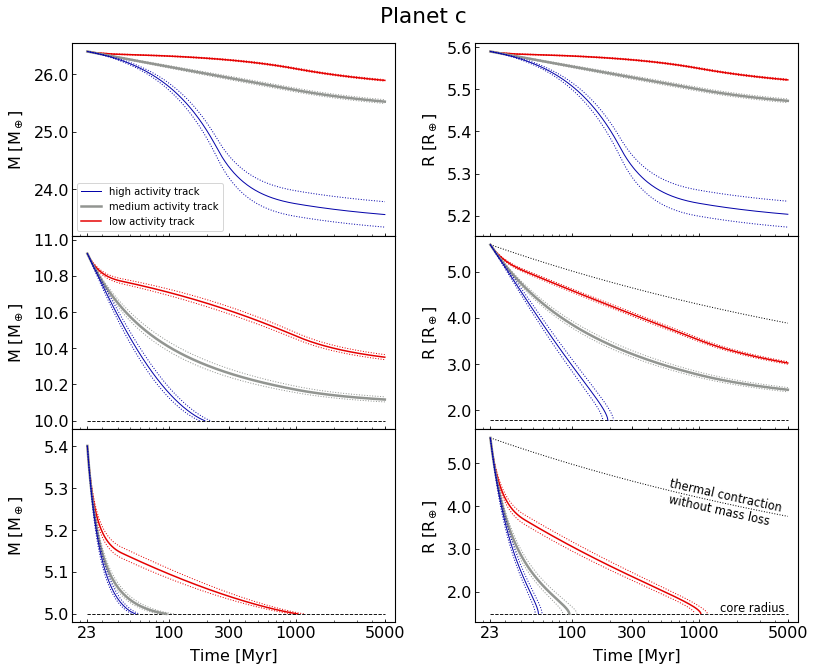

In [25]:
fig, axs = plt.subplots(3,2, figsize=(13,10), sharex=True, sharey=False)
fig.suptitle("Planet c")
fig.subplots_adjust(top=0.93)

# Otegi/heavy
axs[0, 0].plot(t3_c_Otu, M3_c_Otu, label="__nolabel__", ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t1_c_Otu, M1_c_Otu, label="__nolabel__", ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[0, 0].plot(t2_c_Otu, M2_c_Otu, label="__nolabel__", ls=":", color="xkcd:red", lw=1, zorder=1)
axs[0, 0].plot(t3_c_Ot, M3_c_Ot, label="high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t1_c_Ot, M1_c_Ot, label="medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 0].plot(t2_c_Ot, M2_c_Ot, label="low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[0, 0].plot(t3_c_Otl, M3_c_Otl, label="__nolabel__", ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t1_c_Otl, M1_c_Otl, label="__nolabel__", ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[0, 0].plot(t2_c_Otl, M2_c_Otl, label="__nolabel__", ls=":", color="xkcd:red", lw=1, zorder=1)

# 10Mcore
axs[1, 0].plot(t3_c_10u, M3_c_10u, ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t1_c_10u, M1_c_10u, ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[1, 0].plot(t2_c_10u, M2_c_10u, ls=":", color="xkcd:red", lw=1, zorder=1)
axs[1, 0].hlines(pl_c_10.core_mass, t1_c_10u[0], 5000., linestyle="--", color="k", lw=0.9)
axs[1, 0].plot(t3_c_10, M3_c_10, ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t1_c_10, M1_c_10, ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 0].plot(t2_c_10, M2_c_10, ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[1, 0].plot(t3_c_10l, M3_c_10l, ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t1_c_10l, M1_c_10l, ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[1, 0].plot(t2_c_10l, M2_c_10l, ls=":", color="xkcd:red", lw=1, zorder=1)

# 5Mcore
axs[2, 0].plot(t3_c_5u, M3_c_5u, ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t1_c_5u, M1_c_5u, ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[2, 0].plot(t2_c_5u, M2_c_5u, ls=":", color="xkcd:red", lw=1, zorder=1)
axs[2, 0].hlines(pl_c_5.core_mass, t1_c_5u[0], 5000., linestyle="--", color="k", lw=0.9)
axs[2, 0].plot(t3_c_5, M3_c_5, ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t1_c_5, M1_c_5, ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 0].plot(t2_c_5, M2_c_5, ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 0].plot(t3_c_5l, M3_c_5l, ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t1_c_5l, M1_c_5l, ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[2, 0].plot(t2_c_5l, M2_c_5l, ls=":", color="xkcd:red", lw=1, zorder=1)

#radii
# Otegi/heavy
axs[0, 1].plot(t3_c_Otu, R3_c_Otu, ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t1_c_Otu, R1_c_Otu, ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[0, 1].plot(t2_c_Otu, R2_c_Otu, ls=":", color="xkcd:red", lw=1, zorder=1)
axs[0, 1].plot(t3_c_Ot, R3_c_Ot, ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t1_c_Ot, R1_c_Ot, ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 1].plot(t2_c_Ot, R2_c_Ot, ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[0, 1].plot(t3_c_Otl, R3_c_Otl, ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t1_c_Otl, R1_c_Otl, ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[0, 1].plot(t2_c_Otl, R2_c_Otl, ls=":", color="xkcd:red", lw=1, zorder=1)

# 10Mcore
axs[1, 1].plot(t3_c_10u, R3_c_10u, ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t1_c_10u, R1_c_10u, ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[1, 1].plot(t2_c_10u, R2_c_10u, ls=":", color="xkcd:red", lw=1, zorder=1)
age_arr = np.linspace(23., 5000., 1000)
axs[1, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_c_10.core_mass, pl_c_10.fenv, age_arr, pl_c_10.flux, pl_c_10.metallicity), color="k", ls=":", lw=1)
axs[1, 1].hlines(plmo14.calculate_core_radius(pl_c_10.core_mass), pl_c_10.age, 5000., linestyle="--", color="k", lw=0.9)
axs[1, 1].plot(t3_c_10, R3_c_10, ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t1_c_10, R1_c_10, ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 1].plot(t2_c_10, R2_c_10, ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[1, 1].plot(t3_c_10l, R3_c_10l, ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t1_c_10l, R1_c_10l, ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[1, 1].plot(t2_c_10l, R2_c_10l, ls=":", color="xkcd:red", lw=1, zorder=1)

dy = 1.25
axs[2, 1].text(575, 3.19+dy, "thermal contraction", fontsize=11.5, rotation=-12.5)
axs[2, 1].text(570, 2.82+dy, "without mass loss", fontsize=11.5, rotation=-12.5)

# 5 mcore
axs[2, 1].plot(t3_c_5u, (R3_c_5u), ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t1_c_5u, (R1_c_5u), ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[2, 1].plot(t2_c_5u, (R2_c_5u), ls=":", color="xkcd:red", lw=1, zorder=1)
axs[2, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_c_5.core_mass, pl_c_5.fenv, age_arr, pl_c_5.flux, pl_c_5.metallicity), color="k", ls=":", lw=1)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_c_5.core_mass), pl_c_5.age, 5000., linestyle="--", color="k", lw=0.9)
axs[2, 1].text(1475, 1.55, "core radius", fontsize=11.5)
axs[2, 1].plot(t3_c_5, (R3_c_5), ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t1_c_5, (R1_c_5), ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 1].plot(t2_c_5, (R2_c_5), ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 1].plot(t3_c_5l, (R3_c_5l), ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t1_c_5l, (R1_c_5l), ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[2, 1].plot(t2_c_5l, (R2_c_5l), ls=":", color="xkcd:red", lw=1, zorder=1)

axs[0, 0].legend(fontsize=10, loc=3)
for ax in [axs[0, 0], axs[1, 0], axs[2, 0]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('M [M$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

ylim = axs[2, 0].get_ylim()
axs[2, 0].set_ylim(top=ylim[1]+0.02)
ylim = axs[1, 0].get_ylim()
axs[1, 0].set_ylim(top=11.02)
    
for ax in [axs[0, 1], axs[1, 1], axs[2, 1]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('R [R$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

plt.subplots_adjust(hspace=0, wspace=0.25)
fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])
#plt.tight_layout()
#plt.savefig("./Plots/planet_c_EVO_eps01_upper_lower_Lx.jpg", dpi=300)
plt.show()

# Differences between upper and lower Lx_age

In [26]:
Lx_up = Lx_age+Lx_age_error
Lx = Lx_age
Lx_lo = Lx_age-Lx_age_error

def calc_fenv(M_tot, M_core):
    return ((M_tot-M_core)/M_tot)*100

# sorry this is really ugly... just jump to the final table below
dfc = pd.DataFrame(columns=["Lx_init", "t_final_med", "t_final_low", "t_final_high", 
                            "M_init", "fenv", "M_final_med", "fenv_med", "M_final_low", "fenv_low", "M_final_high", "fenv_high", 
                            "R_init", "R_final_med", "R_final_low", "R_final_high"])
dfc.loc[0] = [Lx_up, t1_c_5u[M1_c_5u.last_valid_index()], t2_c_5u[M2_c_5u.last_valid_index()], t3_c_5u[M3_c_5u.last_valid_index()], 
              M1_c_5u[0], calc_fenv(M1_c_5u[0], 5.0), 
              M1_c_5u[M1_c_5u.last_valid_index()], calc_fenv(M1_c_5u[M1_c_5u.last_valid_index()], 5.0), 
              M2_c_5u[M2_c_5u.last_valid_index()], calc_fenv(M2_c_5u[M2_c_5u.last_valid_index()], 5.0), 
              M3_c_5u[M3_c_5u.last_valid_index()], calc_fenv(M3_c_5u[M3_c_5u.last_valid_index()], 5.0), 
              R1_c_5u[0], R1_c_5u[M1_c_5u.last_valid_index()], R2_c_5u[M2_c_5u.last_valid_index()], R3_c_5u[M3_c_5u.last_valid_index()]]
dfc.loc[1] = [Lx, t1_c_5[M1_c_5.last_valid_index()], t2_c_5[M2_c_5.last_valid_index()], t3_c_5[M3_c_5.last_valid_index()], 
              M1_c_5[0], calc_fenv(M1_c_5[0], 5.0), 
              M1_c_5[M1_c_5.last_valid_index()], calc_fenv(M1_c_5[M1_c_5.last_valid_index()], 5.0), 
              M2_c_5[M2_c_5.last_valid_index()], calc_fenv(M2_c_5[M2_c_5.last_valid_index()], 5.0), 
              M3_c_5[M3_c_5.last_valid_index()], calc_fenv(M3_c_5[M3_c_5.last_valid_index()], 5.0), 
              R1_c_5[0], R1_c_5[M1_c_5.last_valid_index()], R2_c_5[M2_c_5.last_valid_index()], R3_c_5[M3_c_5.last_valid_index()]]
dfc.loc[2] = [Lx_lo, t1_c_5l[M1_c_5l.last_valid_index()], t2_c_5l[M2_c_5l.last_valid_index()], t3_c_5l[M3_c_5l.last_valid_index()], 
              M1_c_5l[0], calc_fenv(M1_c_5l[0], 5.0), 
              M1_c_5l[M1_c_5l.last_valid_index()], calc_fenv(M1_c_5l[M1_c_5l.last_valid_index()], 5.0), 
              M2_c_5l[M2_c_5l.last_valid_index()], calc_fenv(M2_c_5l[M2_c_5l.last_valid_index()], 5.0), 
              M3_c_5l[M3_c_5l.last_valid_index()], calc_fenv(M3_c_5l[M3_c_5l.last_valid_index()], 5.0), 
              R1_c_5l[0], R1_c_5l[M1_c_5l.last_valid_index()], R2_c_5l[M2_c_5l.last_valid_index()], R3_c_5l[M3_c_5l.last_valid_index()]]

dfc.loc[3] = [Lx_up, t1_c_10u[M1_c_10u.last_valid_index()], t2_c_10u[M2_c_10u.last_valid_index()], t3_c_10u[M3_c_10u.last_valid_index()], 
              M1_c_10u[0], calc_fenv(M1_c_10u[0], 5.0), 
              M1_c_10u[M1_c_10u.last_valid_index()], calc_fenv(M1_c_10u[M1_c_10u.last_valid_index()], 5.0), 
              M2_c_10u[M2_c_10u.last_valid_index()], calc_fenv(M2_c_10u[M2_c_10u.last_valid_index()], 5.0), 
              M3_c_10u[M3_c_10u.last_valid_index()], calc_fenv(M3_c_10u[M3_c_10u.last_valid_index()], 5.0), 
              R1_c_10u[0], R1_c_10u[M1_c_10u.last_valid_index()], R2_c_10u[M2_c_10u.last_valid_index()], R3_c_10u[M3_c_10u.last_valid_index()]]
dfc.loc[4] = [Lx, t1_c_10[M1_c_10.last_valid_index()], t2_c_10[M2_c_10.last_valid_index()], t3_c_10[M3_c_10.last_valid_index()], 
              M1_c_10[0], calc_fenv(M1_c_10[0], 5.0), 
              M1_c_10[M1_c_10.last_valid_index()], calc_fenv(M1_c_10[M1_c_10.last_valid_index()], 5.0), 
              M2_c_10[M2_c_10.last_valid_index()], calc_fenv(M2_c_10[M2_c_10.last_valid_index()], 5.0), 
              M3_c_10[M3_c_10.last_valid_index()], calc_fenv(M3_c_10[M3_c_10.last_valid_index()], 5.0), 
              R1_c_10[0], R1_c_10[M1_c_10.last_valid_index()], R2_c_10[M2_c_10.last_valid_index()], R3_c_10[M3_c_10.last_valid_index()]]
dfc.loc[5] = [Lx_lo, t1_c_10l[M1_c_10l.last_valid_index()], t2_c_10l[M2_c_10l.last_valid_index()], t3_c_10l[M3_c_10l.last_valid_index()], 
              M1_c_10l[0], calc_fenv(M1_c_10l[0], 5.0), 
              M1_c_10l[M1_c_10l.last_valid_index()], calc_fenv(M1_c_10l[M1_c_10l.last_valid_index()], 5.0), 
              M2_c_10l[M2_c_10l.last_valid_index()], calc_fenv(M2_c_10l[M2_c_10l.last_valid_index()], 5.0), 
              M3_c_10l[M3_c_10l.last_valid_index()], calc_fenv(M3_c_10l[M3_c_10l.last_valid_index()], 5.0), 
              R1_c_10l[0], R1_c_10l[M1_c_10l.last_valid_index()], R2_c_10l[M2_c_10l.last_valid_index()], R3_c_10l[M3_c_10l.last_valid_index()]]

dfc.loc[6] = [Lx_up, t1_c_Otu[M1_c_Otu.last_valid_index()], t2_c_Otu[M2_c_Otu.last_valid_index()], t3_c_Otu[M3_c_Otu.last_valid_index()], 
              M1_c_Otu[0], calc_fenv(M1_c_Otu[0], 5.0), 
              M1_c_Otu[M1_c_Otu.last_valid_index()], calc_fenv(M1_c_Otu[M1_c_Otu.last_valid_index()], 5.0), 
              M2_c_Otu[M2_c_Otu.last_valid_index()], calc_fenv(M2_c_Otu[M2_c_Otu.last_valid_index()], 5.0), 
              M3_c_Otu[M3_c_Otu.last_valid_index()], calc_fenv(M3_c_Otu[M3_c_Otu.last_valid_index()], 5.0), 
              R1_c_Otu[0], R1_c_Otu[M1_c_Otu.last_valid_index()], R2_c_Otu[M2_c_Otu.last_valid_index()], R3_c_Otu[M3_c_Otu.last_valid_index()]]
dfc.loc[7] = [Lx, t1_c_Ot[M1_c_Ot.last_valid_index()], t2_c_Ot[M2_c_Ot.last_valid_index()], t3_c_Ot[M3_c_Ot.last_valid_index()], 
              M1_c_Ot[0], calc_fenv(M1_c_Ot[0], 5.0), 
              M1_c_Ot[M1_c_Ot.last_valid_index()], calc_fenv(M1_c_Ot[M1_c_Ot.last_valid_index()], 5.0), 
              M2_c_Ot[M2_c_Ot.last_valid_index()], calc_fenv(M2_c_Ot[M2_c_Ot.last_valid_index()], 5.0), 
              M3_c_Ot[M3_c_Ot.last_valid_index()], calc_fenv(M3_c_Ot[M3_c_Ot.last_valid_index()], 5.0), 
              R1_c_Ot[0], R1_c_Ot[M1_c_Ot.last_valid_index()], R2_c_Ot[M2_c_Ot.last_valid_index()], R3_c_Ot[M3_c_Ot.last_valid_index()]]
dfc.loc[8] = [Lx_lo, t1_c_Otl[M1_c_Otl.last_valid_index()], t2_c_Otl[M2_c_Otl.last_valid_index()], t3_c_Otl[M3_c_Otl.last_valid_index()], 
              M1_c_Otl[0], calc_fenv(M1_c_Otl[0], 5.0), 
              M1_c_Otl[M1_c_Otl.last_valid_index()], calc_fenv(M1_c_Otl[M1_c_Otl.last_valid_index()], 5.0), 
              M2_c_Otl[M2_c_Otl.last_valid_index()], calc_fenv(M2_c_Otl[M2_c_Otl.last_valid_index()], 5.0), 
              M3_c_Otl[M3_c_Otl.last_valid_index()], calc_fenv(M3_c_Otl[M3_c_Otl.last_valid_index()], 5.0), 
              R1_c_Otl[0], R1_c_Otl[M1_c_Otl.last_valid_index()], R2_c_Otl[M2_c_Otl.last_valid_index()], R3_c_Otl[M3_c_Otl.last_valid_index()]]
dfc = dfc.round(3)

###############################################################################################################################
dfd = pd.DataFrame(columns=["Lx_init", "t_final_high", "t_final_med", "t_final_low", 
                            "M_init", "fenv", "M_final_high", "fenv_high", "M_final_med", "fenv_med", "M_final_low", "fenv_low", 
                            "R_init", "R_final_high", "R_final_med", "R_final_low"])
dfd.loc[0] = [Lx_up, t1_d_5u[M1_d_5u.last_valid_index()], t2_d_5u[M2_d_5u.last_valid_index()], t3_d_5u[M3_d_5u.last_valid_index()], 
              M1_d_5u[0], calc_fenv(M1_d_5u[0], 5.0), 
              M1_d_5u[M1_d_5u.last_valid_index()], calc_fenv(M1_d_5u[M1_d_5u.last_valid_index()], 5.0), 
              M2_d_5u[M2_d_5u.last_valid_index()], calc_fenv(M2_d_5u[M2_d_5u.last_valid_index()], 5.0), 
              M3_d_5u[M3_d_5u.last_valid_index()], calc_fenv(M3_d_5u[M3_d_5u.last_valid_index()], 5.0), 
              R1_d_5u[0], R1_d_5u[M1_d_5u.last_valid_index()], R2_d_5u[M2_d_5u.last_valid_index()], R3_d_5u[M3_d_5u.last_valid_index()]]
dfd.loc[1] = [Lx, t1_d_5[M1_d_5.last_valid_index()], t2_d_5[M2_d_5.last_valid_index()], t3_d_5[M3_d_5.last_valid_index()], 
              M1_d_5[0], calc_fenv(M1_d_5[0], 5.0), 
              M1_d_5[M1_d_5.last_valid_index()], calc_fenv(M1_d_5[M1_d_5.last_valid_index()], 5.0), 
              M2_d_5[M2_d_5.last_valid_index()], calc_fenv(M2_d_5[M2_d_5.last_valid_index()], 5.0), 
              M3_d_5[M3_d_5.last_valid_index()], calc_fenv(M3_d_5[M3_d_5.last_valid_index()], 5.0), 
              R1_d_5[0], R1_d_5[M1_d_5.last_valid_index()], R2_d_5[M2_d_5.last_valid_index()], R3_d_5[M3_d_5.last_valid_index()]]
dfd.loc[2] = [Lx_lo, t1_d_5l[M1_d_5l.last_valid_index()], t2_d_5l[M2_d_5l.last_valid_index()], t3_d_5l[M3_d_5l.last_valid_index()], 
              M1_d_5l[0], calc_fenv(M1_d_5l[0], 5.0), 
              M1_d_5l[M1_d_5l.last_valid_index()], calc_fenv(M1_d_5l[M1_d_5l.last_valid_index()], 5.0), 
              M2_d_5l[M2_d_5l.last_valid_index()], calc_fenv(M2_d_5l[M2_d_5l.last_valid_index()], 5.0), 
              M3_d_5l[M3_d_5l.last_valid_index()], calc_fenv(M3_d_5l[M3_d_5l.last_valid_index()], 5.0), 
              R1_d_5l[0], R1_d_5l[M1_d_5l.last_valid_index()], R2_d_5l[M2_d_5l.last_valid_index()], R3_d_5l[M3_d_5l.last_valid_index()]]

dfd.loc[3] = [Lx_up, t1_d_10u[M1_d_10u.last_valid_index()], t2_d_10u[M2_d_10u.last_valid_index()], t3_d_10u[M3_d_10u.last_valid_index()], 
              M1_d_10u[0], calc_fenv(M1_d_10u[0], 5.0), 
              M1_d_10u[M1_d_10u.last_valid_index()], calc_fenv(M1_d_10u[M1_d_10u.last_valid_index()], 5.0), 
              M2_d_10u[M2_d_10u.last_valid_index()], calc_fenv(M2_d_10u[M2_d_10u.last_valid_index()], 5.0), 
              M3_d_10u[M3_d_10u.last_valid_index()], calc_fenv(M3_d_10u[M3_d_10u.last_valid_index()], 5.0), 
              R1_d_10u[0], R1_d_10u[M1_d_10u.last_valid_index()], R2_d_10u[M2_d_10u.last_valid_index()], R3_d_10u[M3_d_10u.last_valid_index()]]
dfd.loc[4] = [Lx, t1_d_10[M1_d_10.last_valid_index()], t2_d_10[M2_d_10.last_valid_index()], t3_d_10[M3_d_10.last_valid_index()], 
              M1_d_10[0], calc_fenv(M1_d_10[0], 5.0), 
              M1_d_10[M1_d_10.last_valid_index()], calc_fenv(M1_d_10[M1_d_10.last_valid_index()], 5.0), 
              M2_d_10[M2_d_10.last_valid_index()], calc_fenv(M2_d_10[M2_d_10.last_valid_index()], 5.0), 
              M3_d_10[M3_d_10.last_valid_index()], calc_fenv(M3_d_10[M3_d_10.last_valid_index()], 5.0), 
              R1_d_10[0], R1_d_10[M1_d_10.last_valid_index()], R2_d_10[M2_d_10.last_valid_index()], R3_d_10[M3_d_10.last_valid_index()]]
dfd.loc[5] = [Lx_lo, t1_d_10l[M1_d_10l.last_valid_index()], t2_d_10l[M2_d_10l.last_valid_index()], t3_d_10l[M3_d_10l.last_valid_index()], 
              M1_d_10l[0], calc_fenv(M1_d_10l[0], 5.0), 
              M1_d_10l[M1_d_10l.last_valid_index()], calc_fenv(M1_d_10l[M1_d_10l.last_valid_index()], 5.0), 
              M2_d_10l[M2_d_10l.last_valid_index()], calc_fenv(M2_d_10l[M2_d_10l.last_valid_index()], 5.0), 
              M3_d_10l[M3_d_10l.last_valid_index()], calc_fenv(M3_d_10l[M3_d_10l.last_valid_index()], 5.0), 
              R1_d_10l[0], R1_d_10l[M1_d_10l.last_valid_index()], R2_d_10l[M2_d_10l.last_valid_index()], R3_d_10l[M3_d_10l.last_valid_index()]]

dfd.loc[6] = [Lx_up, t1_d_Otu[M1_d_Otu.last_valid_index()], t2_d_Otu[M2_d_Otu.last_valid_index()], t3_d_Otu[M3_d_Otu.last_valid_index()], 
              M1_d_Otu[0], calc_fenv(M1_d_Otu[0], 5.0), 
              M1_d_Otu[M1_d_Otu.last_valid_index()], calc_fenv(M1_d_Otu[M1_d_Otu.last_valid_index()], 5.0), 
              M2_d_Otu[M2_d_Otu.last_valid_index()], calc_fenv(M2_d_Otu[M2_d_Otu.last_valid_index()], 5.0), 
              M3_d_Otu[M3_d_Otu.last_valid_index()], calc_fenv(M3_d_Otu[M3_d_Otu.last_valid_index()], 5.0), 
              R1_d_Otu[0], R1_d_Otu[M1_d_Otu.last_valid_index()], R2_d_Otu[M2_d_Otu.last_valid_index()], R3_d_Otu[M3_d_Otu.last_valid_index()]]
dfd.loc[7] = [Lx, t1_d_Ot[M1_d_Ot.last_valid_index()], t2_d_Ot[M2_d_Ot.last_valid_index()], t3_d_Ot[M3_d_Ot.last_valid_index()], 
              M1_d_Ot[0], calc_fenv(M1_d_Ot[0], 5.0), 
              M1_d_Ot[M1_d_Ot.last_valid_index()], calc_fenv(M1_d_Ot[M1_d_Ot.last_valid_index()], 5.0), 
              M2_d_Ot[M2_d_Ot.last_valid_index()], calc_fenv(M2_d_Ot[M2_d_Ot.last_valid_index()], 5.0), 
              M3_d_Ot[M3_d_Ot.last_valid_index()], calc_fenv(M3_d_Ot[M3_d_Ot.last_valid_index()], 5.0), 
              R1_d_Ot[0], R1_d_Ot[M1_d_Ot.last_valid_index()], R2_d_Ot[M2_d_Ot.last_valid_index()], R3_d_Ot[M3_d_Ot.last_valid_index()]]
dfd.loc[8] = [Lx_lo, t1_d_Otl[M1_d_Otl.last_valid_index()], t2_d_Otl[M2_d_Otl.last_valid_index()], t3_d_Otl[M3_d_Otl.last_valid_index()], 
              M1_d_Otl[0], calc_fenv(M1_d_Otl[0], 5.0), 
              M1_d_Otl[M1_d_Otl.last_valid_index()], calc_fenv(M1_d_Otl[M1_d_Otl.last_valid_index()], 5.0), 
              M2_d_Otl[M2_d_Otl.last_valid_index()], calc_fenv(M2_d_Otl[M2_d_Otl.last_valid_index()], 5.0), 
              M3_d_Otl[M3_d_Otl.last_valid_index()], calc_fenv(M3_d_Otl[M3_d_Otl.last_valid_index()], 5.0), 
              R1_d_Otl[0], R1_d_Otl[M1_d_Otl.last_valid_index()], R2_d_Otl[M2_d_Otl.last_valid_index()], R3_d_Otl[M3_d_Otl.last_valid_index()]]
dfd = dfd.round(3)

###############################################################################################################################
dfb = pd.DataFrame(columns=["Lx_init", "t_final_high", "t_final_med", "t_final_low", 
                            "M_init", "fenv", "M_final_high", "fenv_high", "M_final_med", "fenv_med", "M_final_low", "fenv_low", 
                            "R_init", "R_final_high", "R_final_med", "R_final_low"])
dfb.loc[0] = [Lx_up, t1_b_5u[M1_b_5u.last_valid_index()], t2_b_5u[M2_b_5u.last_valid_index()], t3_b_5u[M3_b_5u.last_valid_index()], 
              M1_b_5u[0], calc_fenv(M1_b_5u[0], 5.0), 
              M1_b_5u[M1_b_5u.last_valid_index()], calc_fenv(M1_b_5u[M1_b_5u.last_valid_index()], 5.0), 
              M2_b_5u[M2_b_5u.last_valid_index()], calc_fenv(M2_b_5u[M2_b_5u.last_valid_index()], 5.0), 
              M3_b_5u[M3_b_5u.last_valid_index()], calc_fenv(M3_b_5u[M3_b_5u.last_valid_index()], 5.0), 
              R1_b_5u[0], R1_b_5u[M1_b_5u.last_valid_index()], R2_b_5u[M2_b_5u.last_valid_index()], R3_b_5u[M3_b_5u.last_valid_index()]]
dfb.loc[1] = [Lx, t1_b_5[M1_b_5.last_valid_index()], t2_b_5[M2_b_5.last_valid_index()], t3_b_5[M3_b_5.last_valid_index()], 
              M1_b_5[0], calc_fenv(M1_b_5[0], 5.0), 
              M1_b_5[M1_b_5.last_valid_index()], calc_fenv(M1_b_5[M1_b_5.last_valid_index()], 5.0), 
              M2_b_5[M2_b_5.last_valid_index()], calc_fenv(M2_b_5[M2_b_5.last_valid_index()], 5.0), 
              M3_b_5[M3_b_5.last_valid_index()], calc_fenv(M3_b_5[M3_b_5.last_valid_index()], 5.0), 
              R1_b_5[0], R1_b_5[M1_b_5.last_valid_index()], R2_b_5[M2_b_5.last_valid_index()], R3_b_5[M3_b_5.last_valid_index()]]
dfb.loc[2] = [Lx_lo, t1_b_5l[M1_b_5l.last_valid_index()], t2_b_5l[M2_b_5l.last_valid_index()], t3_b_5l[M3_b_5l.last_valid_index()], 
              M1_b_5l[0], calc_fenv(M1_b_5l[0], 5.0), 
              M1_b_5l[M1_b_5l.last_valid_index()], calc_fenv(M1_b_5l[M1_b_5l.last_valid_index()], 5.0), 
              M2_b_5l[M2_b_5l.last_valid_index()], calc_fenv(M2_b_5l[M2_b_5l.last_valid_index()], 5.0), 
              M3_b_5l[M3_b_5l.last_valid_index()], calc_fenv(M3_b_5l[M3_b_5l.last_valid_index()], 5.0), 
              R1_b_5l[0], R1_b_5l[M1_b_5l.last_valid_index()], R2_b_5l[M2_b_5l.last_valid_index()], R3_b_5l[M3_b_5l.last_valid_index()]]

dfb.loc[3] = [Lx_up, t1_b_10u[M1_b_10u.last_valid_index()], t2_b_10u[M2_b_10u.last_valid_index()], t3_b_10u[M3_b_10u.last_valid_index()], 
              M1_b_10u[0], calc_fenv(M1_b_10u[0], 5.0), 
              M1_b_10u[M1_b_10u.last_valid_index()], calc_fenv(M1_b_10u[M1_b_10u.last_valid_index()], 5.0), 
              M2_b_10u[M2_b_10u.last_valid_index()], calc_fenv(M2_b_10u[M2_b_10u.last_valid_index()], 5.0), 
              M3_b_10u[M3_b_10u.last_valid_index()], calc_fenv(M3_b_10u[M3_b_10u.last_valid_index()], 5.0), 
              R1_b_10u[0], R1_b_10u[M1_b_10u.last_valid_index()], R2_b_10u[M2_b_10u.last_valid_index()], R3_b_10u[M3_b_10u.last_valid_index()]]
dfb.loc[4] = [Lx, t1_b_10[M1_b_10.last_valid_index()], t2_b_10[M2_b_10.last_valid_index()], t3_b_10[M3_b_10.last_valid_index()], 
              M1_b_10[0], calc_fenv(M1_b_10[0], 5.0), 
              M1_b_10[M1_b_10.last_valid_index()], calc_fenv(M1_b_10[M1_b_10.last_valid_index()], 5.0), 
              M2_b_10[M2_b_10.last_valid_index()], calc_fenv(M2_b_10[M2_b_10.last_valid_index()], 5.0), 
              M3_b_10[M3_b_10.last_valid_index()], calc_fenv(M3_b_10[M3_b_10.last_valid_index()], 5.0), 
              R1_b_10[0], R1_b_10[M1_b_10.last_valid_index()], R2_b_10[M2_b_10.last_valid_index()], R3_b_10[M3_b_10.last_valid_index()]]
dfb.loc[5] = [Lx_lo, t1_b_10l[M1_b_10l.last_valid_index()], t2_b_10l[M2_b_10l.last_valid_index()], t3_b_10l[M3_b_10l.last_valid_index()], 
              M1_b_10l[0], calc_fenv(M1_b_10l[0], 5.0), 
              M1_b_10l[M1_b_10l.last_valid_index()], calc_fenv(M1_b_10l[M1_b_10l.last_valid_index()], 5.0), 
              M2_b_10l[M2_b_10l.last_valid_index()], calc_fenv(M2_b_10l[M2_b_10l.last_valid_index()], 5.0), 
              M3_b_10l[M3_b_10l.last_valid_index()], calc_fenv(M3_b_10l[M3_b_10l.last_valid_index()], 5.0), 
              R1_b_10l[0], R1_b_10l[M1_b_10l.last_valid_index()], R2_b_10l[M2_b_10l.last_valid_index()], R3_b_10l[M3_b_10l.last_valid_index()]]

dfb.loc[6] = [Lx_up, t1_b_Otu[M1_b_Otu.last_valid_index()], t2_b_Otu[M2_b_Otu.last_valid_index()], t3_b_Otu[M3_b_Otu.last_valid_index()], 
              M1_b_Otu[0], calc_fenv(M1_b_Otu[0], 5.0), 
              M1_b_Otu[M1_b_Otu.last_valid_index()], calc_fenv(M1_b_Otu[M1_b_Otu.last_valid_index()], 5.0), 
              M2_b_Otu[M2_b_Otu.last_valid_index()], calc_fenv(M2_b_Otu[M2_b_Otu.last_valid_index()], 5.0), 
              M3_b_Otu[M3_b_Otu.last_valid_index()], calc_fenv(M3_b_Otu[M3_b_Otu.last_valid_index()], 5.0), 
              R1_b_Otu[0], R1_b_Otu[M1_b_Otu.last_valid_index()], R2_b_Otu[M2_b_Otu.last_valid_index()], R3_b_Otu[M3_b_Otu.last_valid_index()]]
dfb.loc[7] = [Lx, t1_b_Ot[M1_b_Ot.last_valid_index()], t2_b_Ot[M2_b_Ot.last_valid_index()], t3_b_Ot[M3_b_Ot.last_valid_index()], 
              M1_b_Ot[0], calc_fenv(M1_b_Ot[0], 5.0), 
              M1_b_Ot[M1_b_Ot.last_valid_index()], calc_fenv(M1_b_Ot[M1_b_Ot.last_valid_index()], 5.0), 
              M2_b_Ot[M2_b_Ot.last_valid_index()], calc_fenv(M2_b_Ot[M2_b_Ot.last_valid_index()], 5.0), 
              M3_b_Ot[M3_b_Ot.last_valid_index()], calc_fenv(M3_b_Ot[M3_b_Ot.last_valid_index()], 5.0), 
              R1_b_Ot[0], R1_b_Ot[M1_b_Ot.last_valid_index()], R2_b_Ot[M2_b_Ot.last_valid_index()], R3_b_Ot[M3_b_Ot.last_valid_index()]]
dfb.loc[8] = [Lx_lo, t1_b_Otl[M1_b_Otl.last_valid_index()], t2_b_Otl[M2_b_Otl.last_valid_index()], t3_b_Otl[M3_b_Otl.last_valid_index()], 
              M1_b_Otl[0], calc_fenv(M1_b_Otl[0], 5.0), 
              M1_b_Otl[M1_b_Otl.last_valid_index()], calc_fenv(M1_b_Otl[M1_b_Otl.last_valid_index()], 5.0), 
              M2_b_Otl[M2_b_Otl.last_valid_index()], calc_fenv(M2_b_Otl[M2_b_Otl.last_valid_index()], 5.0), 
              M3_b_Otl[M3_b_Otl.last_valid_index()], calc_fenv(M3_b_Otl[M3_b_Otl.last_valid_index()], 5.0), 
              R1_b_Otl[0], R1_b_Otl[M1_b_Otl.last_valid_index()], R2_b_Otl[M2_b_Otl.last_valid_index()], R3_b_Otl[M3_b_Otl.last_valid_index()]]
dfb = dfb.round(3)
###############################################################################################################################
dfe = pd.DataFrame(columns=["Lx_init", "t_final_high", "t_final_med", "t_final_low", 
                            "M_init", "fenv", "M_final_high", "fenv_high", "M_final_med", "fenv_med", "M_final_low", "fenv_low", 
                            "R_init", "R_final_high", "R_final_med", "R_final_low"])
dfe.loc[0] = [Lx_up, t1_e_5u[M1_e_5u.last_valid_index()], t2_e_5u[M2_e_5u.last_valid_index()], t3_e_5u[M3_e_5u.last_valid_index()], 
              M1_e_5u[0], calc_fenv(M1_e_5u[0], 5.0), 
              M1_e_5u[M1_e_5u.last_valid_index()], calc_fenv(M1_e_5u[M1_e_5u.last_valid_index()], 5.0), 
              M2_e_5u[M2_e_5u.last_valid_index()], calc_fenv(M2_e_5u[M2_e_5u.last_valid_index()], 5.0), 
              M3_e_5u[M3_e_5u.last_valid_index()], calc_fenv(M3_e_5u[M3_e_5u.last_valid_index()], 5.0), 
              R1_e_5u[0], R1_e_5u[M1_e_5u.last_valid_index()], R2_e_5u[M2_e_5u.last_valid_index()], R3_e_5u[M3_e_5u.last_valid_index()]]
dfe.loc[1] = [Lx, t1_e_5[M1_e_5.last_valid_index()], t2_e_5[M2_e_5.last_valid_index()], t3_e_5[M3_e_5.last_valid_index()], 
              M1_e_5[0], calc_fenv(M1_e_5[0], 5.0), 
              M1_e_5[M1_e_5.last_valid_index()], calc_fenv(M1_e_5[M1_e_5.last_valid_index()], 5.0), 
              M2_e_5[M2_e_5.last_valid_index()], calc_fenv(M2_e_5[M2_e_5.last_valid_index()], 5.0), 
              M3_e_5[M3_e_5.last_valid_index()], calc_fenv(M3_e_5[M3_e_5.last_valid_index()], 5.0), 
              R1_e_5[0], R1_e_5[M1_e_5.last_valid_index()], R2_e_5[M2_e_5.last_valid_index()], R3_e_5[M3_e_5.last_valid_index()]]
dfe.loc[2] = [Lx_lo, t1_e_5l[M1_e_5l.last_valid_index()], t2_e_5l[M2_e_5l.last_valid_index()], t3_e_5l[M3_e_5l.last_valid_index()], 
              M1_e_5l[0], calc_fenv(M1_e_5l[0], 5.0), 
              M1_e_5l[M1_e_5l.last_valid_index()], calc_fenv(M1_e_5l[M1_e_5l.last_valid_index()], 5.0), 
              M2_e_5l[M2_e_5l.last_valid_index()], calc_fenv(M2_e_5l[M2_e_5l.last_valid_index()], 5.0), 
              M3_e_5l[M3_e_5l.last_valid_index()], calc_fenv(M3_e_5l[M3_e_5l.last_valid_index()], 5.0), 
              R1_e_5l[0], R1_e_5l[M1_e_5l.last_valid_index()], R2_e_5l[M2_e_5l.last_valid_index()], R3_e_5l[M3_e_5l.last_valid_index()]]

dfe.loc[3] = [Lx_up, t1_e_10u[M1_e_10u.last_valid_index()], t2_e_10u[M2_e_10u.last_valid_index()], t3_e_10u[M3_e_10u.last_valid_index()], 
              M1_e_10u[0], calc_fenv(M1_e_10u[0], 5.0), 
              M1_e_10u[M1_e_10u.last_valid_index()], calc_fenv(M1_e_10u[M1_e_10u.last_valid_index()], 5.0), 
              M2_e_10u[M2_e_10u.last_valid_index()], calc_fenv(M2_e_10u[M2_e_10u.last_valid_index()], 5.0), 
              M3_e_10u[M3_e_10u.last_valid_index()], calc_fenv(M3_e_10u[M3_e_10u.last_valid_index()], 5.0), 
              R1_e_10u[0], R1_e_10u[M1_e_10u.last_valid_index()], R2_e_10u[M2_e_10u.last_valid_index()], R3_e_10u[M3_e_10u.last_valid_index()]]
dfe.loc[4] = [Lx, t1_e_10[M1_e_10.last_valid_index()], t2_e_10[M2_e_10.last_valid_index()], t3_e_10[M3_e_10.last_valid_index()], 
              M1_e_10[0], calc_fenv(M1_e_10[0], 5.0), 
              M1_e_10[M1_e_10.last_valid_index()], calc_fenv(M1_e_10[M1_e_10.last_valid_index()], 5.0), 
              M2_e_10[M2_e_10.last_valid_index()], calc_fenv(M2_e_10[M2_e_10.last_valid_index()], 5.0), 
              M3_e_10[M3_e_10.last_valid_index()], calc_fenv(M3_e_10[M3_e_10.last_valid_index()], 5.0), 
              R1_e_10[0], R1_e_10[M1_e_10.last_valid_index()], R2_e_10[M2_e_10.last_valid_index()], R3_e_10[M3_e_10.last_valid_index()]]
dfe.loc[5] = [Lx_lo, t1_e_10l[M1_e_10l.last_valid_index()], t2_e_10l[M2_e_10l.last_valid_index()], t3_e_10l[M3_e_10l.last_valid_index()], 
              M1_e_10l[0], calc_fenv(M1_e_10l[0], 5.0), 
              M1_e_10l[M1_e_10l.last_valid_index()], calc_fenv(M1_e_10l[M1_e_10l.last_valid_index()], 5.0), 
              M2_e_10l[M2_e_10l.last_valid_index()], calc_fenv(M2_e_10l[M2_e_10l.last_valid_index()], 5.0), 
              M3_e_10l[M3_e_10l.last_valid_index()], calc_fenv(M3_e_10l[M3_e_10l.last_valid_index()], 5.0), 
              R1_e_10l[0], R1_e_10l[M1_e_10l.last_valid_index()], R2_e_10l[M2_e_10l.last_valid_index()], R3_e_10l[M3_e_10l.last_valid_index()]]

dfe.loc[6] = [Lx_up, t1_e_Otu[M1_e_Otu.last_valid_index()], t2_e_Otu[M2_e_Otu.last_valid_index()], t3_e_Otu[M3_e_Otu.last_valid_index()], 
              M1_e_Otu[0], calc_fenv(M1_e_Otu[0], 5.0), 
              M1_e_Otu[M1_e_Otu.last_valid_index()], calc_fenv(M1_e_Otu[M1_e_Otu.last_valid_index()], 5.0), 
              M2_e_Otu[M2_e_Otu.last_valid_index()], calc_fenv(M2_e_Otu[M2_e_Otu.last_valid_index()], 5.0), 
              M3_e_Otu[M3_e_Otu.last_valid_index()], calc_fenv(M3_e_Otu[M3_e_Otu.last_valid_index()], 5.0), 
              R1_e_Otu[0], R1_e_Otu[M1_e_Otu.last_valid_index()], R2_e_Otu[M2_e_Otu.last_valid_index()], R3_e_Otu[M3_e_Otu.last_valid_index()]]
dfe.loc[7] = [Lx, t1_e_Ot[M1_e_Ot.last_valid_index()], t2_e_Ot[M2_e_Ot.last_valid_index()], t3_e_Ot[M3_e_Ot.last_valid_index()], 
              M1_e_Ot[0], calc_fenv(M1_e_Ot[0], 5.0), 
              M1_e_Ot[M1_e_Ot.last_valid_index()], calc_fenv(M1_e_Ot[M1_e_Ot.last_valid_index()], 5.0), 
              M2_e_Ot[M2_e_Ot.last_valid_index()], calc_fenv(M2_e_Ot[M2_e_Ot.last_valid_index()], 5.0), 
              M3_e_Ot[M3_e_Ot.last_valid_index()], calc_fenv(M3_e_Ot[M3_e_Ot.last_valid_index()], 5.0), 
              R1_e_Ot[0], R1_e_Ot[M1_e_Ot.last_valid_index()], R2_e_Ot[M2_e_Ot.last_valid_index()], R3_e_Ot[M3_e_Ot.last_valid_index()]]
dfe.loc[8] = [Lx_lo, t1_e_Otl[M1_e_Otl.last_valid_index()], t2_e_Otl[M2_e_Otl.last_valid_index()], t3_e_Otl[M3_e_Otl.last_valid_index()], 
              M1_e_Otl[0], calc_fenv(M1_e_Otl[0], 5.0), 
              M1_e_Otl[M1_e_Otl.last_valid_index()], calc_fenv(M1_e_Otl[M1_e_Otl.last_valid_index()], 5.0), 
              M2_e_Otl[M2_e_Otl.last_valid_index()], calc_fenv(M2_e_Otl[M2_e_Otl.last_valid_index()], 5.0), 
              M3_e_Otl[M3_e_Otl.last_valid_index()], calc_fenv(M3_e_Otl[M3_e_Otl.last_valid_index()], 5.0), 
              R1_e_Otl[0], R1_e_Otl[M1_e_Otl.last_valid_index()], R2_e_Otl[M2_e_Otl.last_valid_index()], R3_e_Otl[M3_e_Otl.last_valid_index()]]
dfe = dfe.round(3)

###############################################################################################################################
# concatenate all planets to one dataframe

df_all = pd.concat([dfc, dfd, dfb, dfe], sort=False)
col_planet = ["c"]*9+["d"]*9+["b"]*9+["e"]*9
df_all.insert(0, 'planet', col_planet)
df_all.reset_index(drop=True, inplace=True)
df_all = df_all[['planet', 'Lx_init', 't_final_high','t_final_med', 't_final_low', 
       'M_init', 'fenv', 'M_final_high', 'fenv_high', 'M_final_med', 'fenv_med', 'M_final_low', 'fenv_low',
       'R_init', 'R_final_high', 'R_final_med', 'R_final_low']]
df_all.to_csv("./results_Lx_errors.csv", index=None)

In [27]:
pd.read_csv("./results_Lx_errors.csv")

,planet,Lx_init,t_final_high,t_final_med,t_final_low,M_init,fenv,M_final_high,fenv_high,M_final_med,fenv_med,M_final_low,fenv_low,R_init,R_final_high,R_final_med,R_final_low
0,c,1.440000e+30,51.88,85.3,927.90,5.401,7.421,5.000,0.000,5.000,0.000,5.000,0.000,5.59,1.495,1.495,1.495
1,c,1.300000e+30,54.90,95.9,1035.60,5.401,7.421,5.000,0.000,5.000,0.000,5.000,0.000,5.59,1.495,1.495,1.495
2,c,1.160000e+30,58.64,110.1,1165.90,5.401,7.421,5.000,0.000,5.000,0.000,5.000,0.000,5.59,1.495,1.495,1.495
3,c,1.440000e+30,176.00,5006.4,5007.10,10.922,54.223,10.000,50.000,10.104,50.514,10.337,51.631,5.59,1.778,2.397,2.995
4,c,1.300000e+30,192.80,5005.8,5000.30,10.922,54.223,10.000,50.000,10.117,50.578,10.351,51.694,5.59,1.778,2.441,3.022
5,c,1.160000e+30,213.80,5004.7,5002.40,10.922,54.223,10.000,50.000,10.132,50.651,10.365,51.761,5.59,1.778,2.489,3.051
6,c,1.440000e+30,5006.00,5007.0,5008.00,26.391,81.054,23.346,78.583,25.489,80.384,25.877,80.678,5.59,5.173,5.468,5.521
7,c,1.300000e+30,5007.00,5003.0,5007.00,26.391,81.054,23.564,78.781,25.522,80.409,25.890,80.687,5.59,5.203,5.473,5.523
8,c,1.160000e+30,5007.00,5010.0,5006.00,26.391,81.054,23.787,78.980,25.555,80.434,25.903,80.698,5.59,5.234,5.477,5.524
9,d,1.440000e+30,460.80,5001.9,84.21,5.597,10.665,5.000,0.000,5.025,0.503,5.000,0.000,6.41,1.495,1.954,1.495
